In [1]:
import os
import subprocess
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import flopy

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'font.size': 11})

In [2]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
bins_abspth = os.path.abspath(bins_pth)

Name of calibrated model:

In [3]:
ml_name = 'hagfors_1'
result_ws = os.path.join('..', '2022_03_18_calib') # For inquiries of the calibrated model please send email the corresponding author.
pest_ws = os.path.join(result_ws, 'pest')
mngr_ml = os.path.join(result_ws, 'runmodel', 'model')
observations_pth = os.path.join('..', 'data', 'observations') # Measured data (field obs)
os.listdir(result_ws)

['pest', 'runmodel']

Edit MF6 output control to save a cell budget file (including specific discharge):

In [4]:
sim_mngr = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), mngr_ml)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package rch...
    loading package sto...
    loading package oc...
    loading package npf...
    loading package ic...
    loading package sfr...
    loading package obs...
    loading package ghb...
  loading ims package hagfors_1...


In [5]:
gwf_mngr = sim_mngr.get_model(ml_name)

In [6]:
gwf_mngr.remove_package('oc')

In [7]:
oc = flopy.mf6.ModflowGwfoc(
    gwf_mngr,
    pname='oc',
    budget_filerecord='{}.cbb'.format(ml_name),
    head_filerecord='{}.hds'.format(ml_name),
    headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL')],
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
    printrecord=[('HEAD', 'FIRST'), ('HEAD', 'LAST'), ('BUDGET', 'LAST')]
)

In [8]:
# Enable saving of specific discharge
gwf_mngr.npf.save_specific_discharge = True

In [9]:
# Rewrite simulation files
sim_mngr.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package hagfors_1...
  writing model hagfors_1...
    writing model name file...
    writing package disv...
    writing package rch_ts...
    writing package rch...
    writing package sto...
    writing package npf...
    writing package ic...
    writing package sfr_ts...
    writing package sfr_ts...
    writing package sfr_ts...
    writing package sfr_obs...
    writing package sfr...
    writing package gwf_obs...
    writing package ghb_ts...
    writing package ghb...
    writing package oc...


Use PARREP to replace model with parameters with optimal parameters:

In [10]:
p = subprocess.run([
    'parrep',
    'calib1-wt-cov-linux.par.5', # CHANGE THIS
    'calib1-wt-cov-linux.pst',
    'calib-parrep.pst',
    '0'
], cwd=pest_ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)


PARREP Version 17.3. Watermark Numerical Computing.

Reading parameter value file calib1-wt-cov-linux.par.5 ----->
Data for 1718 parameters read from file calib1-wt-cov-linux.par.5.

Reading file calib1-wt-cov-linux.pst and writing file calib-parrep.pst ----->
File calib-parrep.pst written ok.



Edit the `.pst` file for use in a Windows environment:

In [11]:
with open(os.path.join(pest_ws, 'calib-parrep.pst'), 'r') as file:
    pstfile = file.readlines()

In [12]:
# Locate model command line
model_cmdline = pstfile.index('* model command line\n') + 1
pstfile[model_cmdline] = 'runmodel.bat\n'

In [13]:
pstfile = [i.replace('/', '\\') for i in pstfile]

In [14]:
model_io = pstfile.index('* model command line\n') + 2

In [15]:
pstfile[model_io] = '* model input/output\n'

In [16]:
with open(os.path.join(pest_ws, 'calib-parrep.pst'), 'w') as file:
    for line in pstfile:
        file.write(line)

Copy Windows binaries:

In [17]:
copyfiles = ['agent_hp.exe', 'libiomp5md.dll', 'pest_hp_mkl.exe']

In [18]:
for file in copyfiles:
    shutil.copyfile(os.path.join(bins_pth, file), os.path.join(pest_ws, file))

Create an agent directory and create a copy:

In [19]:
agent_dir = os.path.join(result_ws ,'agent')
if os.path.exists(agent_dir):
    shutil.rmtree(agent_dir)
shutil.copytree(result_ws,agent_dir)
agent_pest_ws = os.path.join(agent_dir, 'pest')

Write run-scripts for both manager and agent:

In [20]:
def write_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [21]:
write_script(os.path.join(pest_ws, 'start_manager.bat'), [
f'''
set PATH=%PATH%;{bins_abspth}
pest_hp_mkl calib-parrep.pst /h :4004
pause
'''
])

In [22]:
write_script(os.path.join(agent_pest_ws, 'start_agent.bat'), [
f'''
set PATH=%PATH%;{bins_abspth}
agent_hp calib-parrep.pst /h %computername%:4004
pause
'''
])

Manually run `start_manager.bat` in pest_ws  
Manually run `start_agent.bat` in agent_pest_ws  

Once the batch files have been run to completion, import the results:

In [23]:
agent_ml, ml_name = os.path.join(agent_dir, 'runmodel', 'model'), 'hagfors_1'

In [24]:
sim_agent = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), agent_ml)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ghb...
    loading package obs...
    loading package sfr...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package oc...
  loading ims package hagfors_1...


In [25]:
gwf_agent = sim_agent.get_model(ml_name)

In [26]:
#sim_agent.run_simulation()

In [27]:
# field measurement positions
meas_pos = pd.read_csv(os.path.join(observations_pth, 'measurement_positions.csv'))

# objective function reduction
ofr = pd.read_csv(os.path.join(pest_ws, 'calib1-wt-cov-linux.ofr'), skiprows=3, delim_whitespace=True)

# get the specific discharge from the cell budget file
cbb_file = os.path.join(agent_ml, f'{ml_name}.cbb')
cbb = flopy.utils.CellBudgetFile(cbb_file)
spdis = cbb.get_data(text="SPDIS")[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf_agent)

# get the head from the head file
head_file = os.path.join(agent_ml, f'{ml_name}.hds')
head = flopy.utils.HeadFile(head_file)
hdata = head.get_alldata()

In [28]:
#Check the budget
mf_list = flopy.utils.Mf6ListBudget(os.path.join(mngr_ml, f"{gwf_agent.name}.lst"), timeunit='days') #MF6ListBudget is different from MfListBudget...*sigh*
incremental, cumulative = mf_list.get_budget()
incrementaldf, cumulativedf = mf_list.get_dataframes(start_datetime="01-09-2017")

incrementaldf

STO-SS_IN  STO-SY_IN        GHB_IN      RCH_IN       SFR_IN  \
2017-01-09    0.00000   0.000000  12763.213867  108.728104  5522.802734   
2021-02-08    0.00403  76.099899  12898.791992  352.324585  5469.566895   

                TOTAL_IN  STO-SS_OUT  STO-SY_OUT      GHB_OUT  RCH_OUT  \
2017-01-09  18394.744141         0.0         0.0  7351.733887      0.0   
2021-02-08  18796.787109         0.0         0.0  7290.606445      0.0   

                 SFR_OUT     TOTAL_OUT    IN-OUT  PERCENT_DISCREPANCY  
2017-01-09  11043.193359  18394.927734 -0.182300                 -0.0  
2021-02-08  11506.180664  18796.787109 -0.000052                 -0.0

No handles with labels found to put in legend.


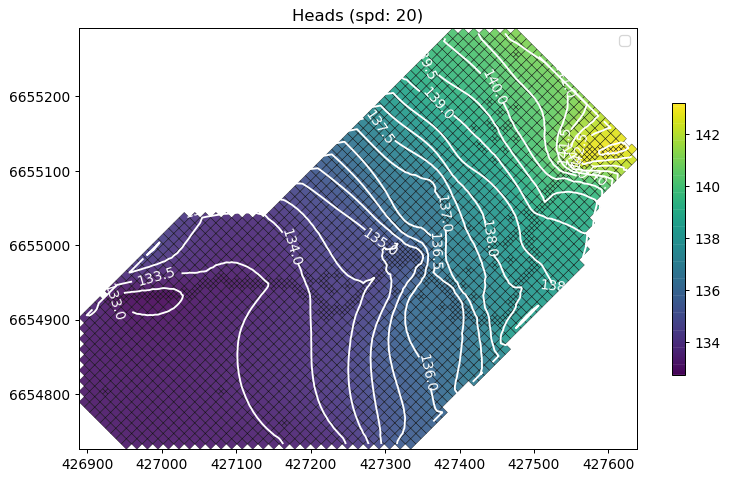

In [29]:
spd = 20

fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25, color='k')
quadmesh = mapview.plot_array(a=hdata[spd], alpha=0.9, masked_values=[1e30])
plt.colorbar(quadmesh, shrink=0.4);

levels = np.arange(130, 145, 0.5)
contour_set = mapview.contour_array(hdata[spd], levels=levels, colors='white')
plt.clabel(contour_set, fmt="%.1f", colors='white', fontsize=11)


plt.title(f'Heads (spd: {spd})')
plt.legend()
plt.show()

In [30]:
(gwf_agent.disv.top.get_data() -  hdata[0]).min()

-0.7729621117460681

No handles with labels found to put in legend.


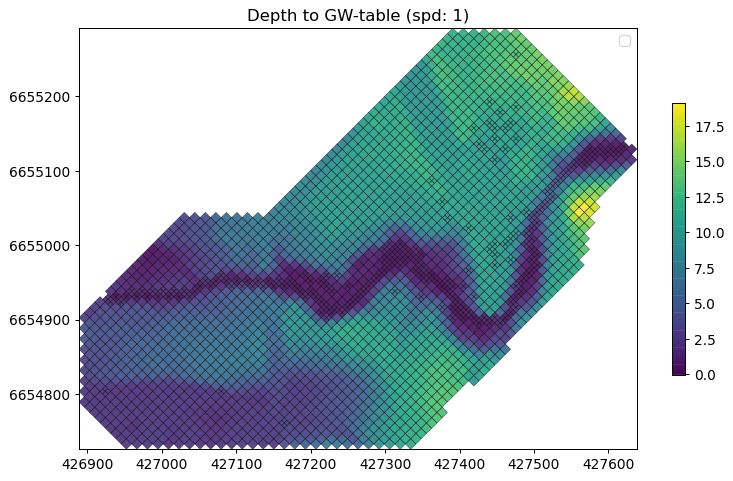

In [31]:
spd = 1

fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25, color='k')
quadmesh = mapview.plot_array(a=gwf_agent.disv.top.get_data() -  hdata[spd], alpha=0.9, masked_values=[1e30])
plt.colorbar(quadmesh, shrink=0.4);

#levels = np.arange(130, 145, 1.0)
#contour_set = mapview.contour_array(hdata[spd], levels=levels, colors='white')
#plt.clabel(contour_set, fmt="%.1f", colors='white', fontsize=11)


plt.title(f'Depth to GW-table (spd: {spd})')
plt.legend()
plt.show()

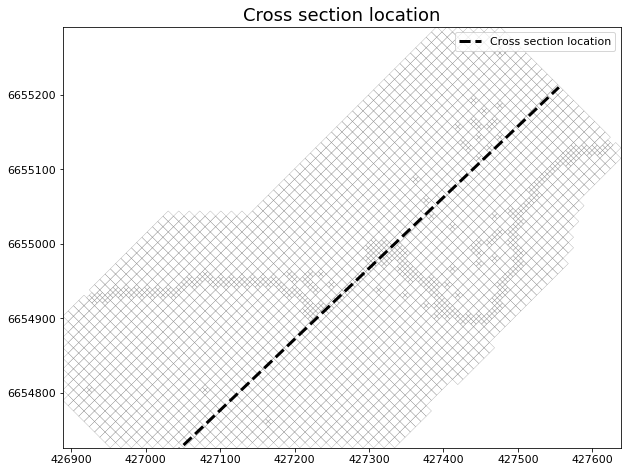

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Cross section location', fontsize=18)

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

xsection = np.array([(427020, 6654700), (427555, 6655210)])
plt.plot(xsection.T[0], xsection.T[1], color='k', linestyle='--', lw=3, label='Cross section location')
    
plt.legend()
plt.show()

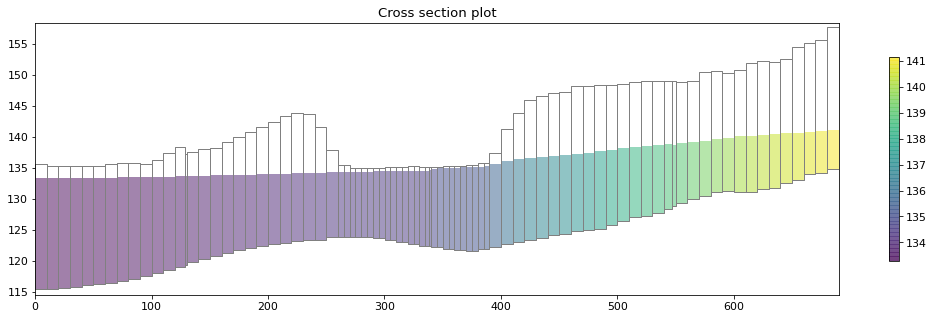

In [33]:
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Cross section plot")

xsect = flopy.plot.PlotCrossSection(model=gwf_agent, line={"line": xsection})
patch_collection = xsect.plot_array(hdata[spd], head=hdata[spd], alpha=0.5)
line_collection = xsect.plot_grid()
cb = plt.colorbar(patch_collection, shrink=0.75)

In [34]:
ofr.round(2)

iteration  measurement  regularisation   heads   stage1    gage1    gage2  \
0          0     11000.00            0.00  999.99  1000.04  1000.00  1000.00   
1          1      6434.82         2350.87  352.89   608.56   577.25   673.71   
2          2      4883.67         1404.45  167.06   504.03   491.38   379.03   
3          3      4080.32         2168.56  135.62   475.49   402.66   270.14   
4          4      3412.02        12402.50  135.18   401.82   353.72   184.64   
5          5      2955.71        12381.80  108.91   334.69   304.43   150.04   
6          6      2683.03        17998.30   87.49   304.98   262.21   123.56   
7          7      2493.50        27971.90   74.61   294.66   221.94   110.41   

   dh_hedstg    >@dts     >@of  heads_d  stage1_d  gage1_d  gage2_d  pflux  \
0    1000.00  1000.00  1000.00  1000.00   1000.00  1000.00  1000.00    0.0   
1     289.57     5.95   569.19   624.79    954.96   959.40   818.55    0.0   
2     245.86     0.62   538.42   511.71    818.52   767.32   459.72    0.0   
3     235.68     5.61   523.85   445.61    701.03   593.62   291.01    0.0   
4     208.94     4.04   524.56   406.30    497.26   486.88   208.68    0.0   
5     191.50     0.09   496.90   403.59    412.76   409.09   143.70    0.0   
6     182.42     0.24   472.30   407.74    373.07   347.70   121.33    0.0   
7     175.31     0.47   448.81   409.38    351.84   298.33   107.75    0.0   

   pof  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  
5  0.0  
6  0.0  
7  0.0

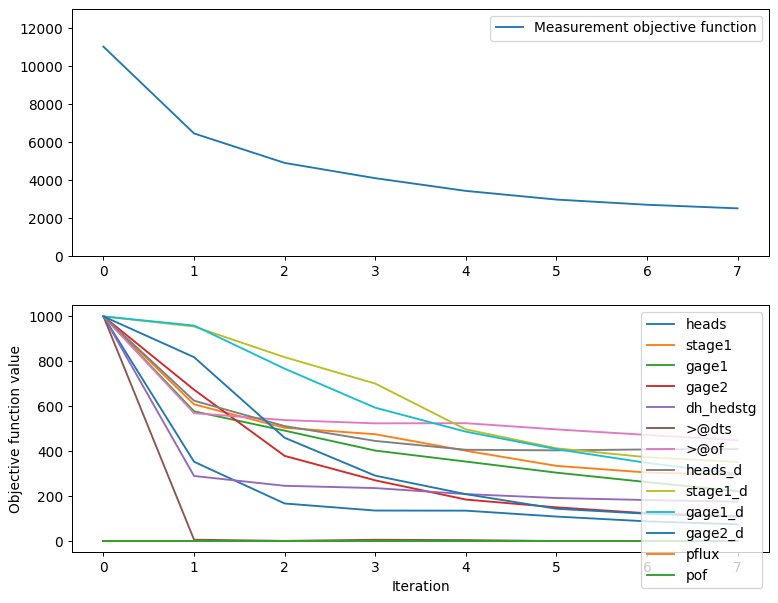

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), dpi=90)

axs[0].plot(ofr['measurement'], label='Measurement objective function')
axs[0].set_ylim([0, 13000])
axs[0].legend()

for col in ofr.columns:
    if col in ['measurement', 'iteration', 'regularisation', 'pleak']:
        continue
    else:
        axs[1].plot(ofr[col], label=col)
        axs[1].legend(fontsize=8)
        
    
plt.xlabel('Iteration')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

In [10]:
reifilename = 'calib1-wt-cov-linux.rei.5'

with open(os.path.join(pest_ws, reifilename), 'r') as file:
    reifile = file.readlines() #pestfile partial parameters

In [11]:
reifile = [i.replace('Cov. Mat.', 'covmat') for i in reifile]

In [12]:
with open(os.path.join(pest_ws, 'calib-parrep.rei'), 'w') as file:
    for line in reifile:
        file.write(line)

In [13]:
# Residuals
rei_df = pd.read_csv(os.path.join(pest_ws, 'calib-parrep.rei'), skiprows=7, delim_whitespace=True)
rei_df.columns = rei_df.columns.str.lower()

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
# Drop regularisation and prediction
rei_df = rei_df[~rei_df.group.str.contains('regul')]
rei_df

name  group   measured    modelled      residual    weight
0          b10-1_1  heads    133.695    133.2147      0.480348  0.897773
1          b10-1_2  heads    133.620    133.1241      0.495926  0.897773
2          b10-1_3  heads    133.480    133.1400      0.339990  0.897773
3          b10-1_4  heads    133.425    133.1398      0.285171  0.897773
4          b14-1_1  heads    140.200    139.8718      0.328216  0.897773
...            ...    ...        ...         ...           ...       ...
172054  of-262_209   pofr -17823.070 -38482.7400  20659.670000  0.000000
172055  of-262_210   pofr -17984.900 -80205.5400  62220.640000  0.000000
172056  of-262_211   pofr -18149.070 -46134.6600  27985.590000  0.000000
172057  of-262_212   pofr -17895.090 -42735.9400  24840.850000  0.000000
172058  of-262_213   pofr -17713.200 -34082.6800  16369.480000  0.000000

[172059 rows x 6 columns]

In [15]:
rei_df['sites'] = [i.split('_')[0] for i in rei_df.name]

In [16]:
rei_df.loc[rei_df['sites'] == 'b2-1']

name    group    measured    modelled  residual    weight sites
13         b2-1_1    heads  137.053500  137.031900  0.021613  0.897773  b2-1
14         b2-1_2    heads  137.048800  137.035300  0.013474  0.897773  b2-1
15         b2-1_3    heads  137.053300  137.038800  0.014535  0.897773  b2-1
16         b2-1_4    heads  137.053800  137.043900  0.009927  0.897773  b2-1
17         b2-1_5    heads  137.055800  137.049300  0.006522  0.897773  b2-1
...           ...      ...         ...         ...       ...       ...   ...
43211  b2-1_d1056  heads_d   -0.129940   -0.244966  0.115026   2.79021  b2-1
43212  b2-1_d1057  heads_d   -0.128291   -0.293596  0.165305   2.79021  b2-1
43213  b2-1_d1058  heads_d   -0.129396   -0.257925  0.128529   2.79021  b2-1
43214  b2-1_d1059  heads_d   -0.126456   -0.212492  0.086036   2.79021  b2-1
43215  b2-1_d1060  heads_d   -0.123855   -0.167060  0.043205   2.79021  b2-1

[2119 rows x 7 columns]

In [17]:
rei_df.group.unique()

array(['heads', 'stage1', 'gage1', 'gage2', 'dh_hedstg', '>@dts', '>@of',
       'heads_d', 'stage1_d', 'gage1_d', 'gage2_d', 'pfluxb', 'pofb',
       'pfluxr', 'pofr'], dtype=object)

In [18]:
# Sites with measured head
heads_sites = rei_df.loc[rei_df['group'] == 'heads'].sites.unique()
stage1_sites = rei_df.loc[rei_df['group'] == 'stage1'].sites.unique()
dh_hedstg_sites = rei_df.loc[rei_df['group'] == 'dh_hedstg'].sites.unique()

Text(0.5, 1.0, 'Heads')

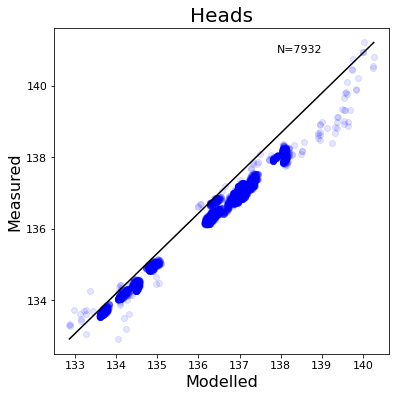

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x = rei_df.loc[rei_df.group == 'heads'].modelled
y = rei_df.loc[rei_df.group == 'heads'].measured
ax.annotate(f'N={len(x)}', xy=(136, 136),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            )
plt.scatter(x, y, alpha=0.1, color='blue')
plt.plot([x.min(), x.max()], [y.min(), y.max()], c='k')
plt.xlabel('Modelled', fontsize=16)
plt.ylabel('Measured', fontsize=16)
plt.title('Heads', fontsize=20)

Text(0.5, 1.0, 'Stream stages')

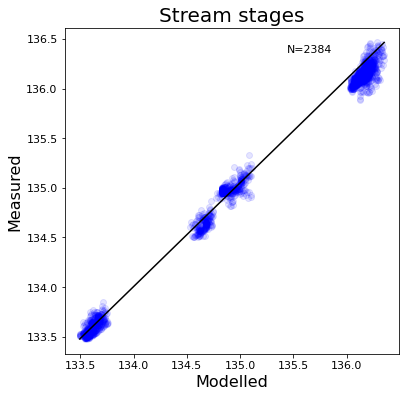

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x = rei_df.loc[rei_df.group == 'stage1'].modelled
y = rei_df.loc[rei_df.group == 'stage1'].measured
plt.scatter(x, y, alpha=0.1, color='blue')
plt.plot([x.min(), x.max()], [y.min(), y.max()], c='k')
ax.annotate(f'N={len(x)}', xy=(136, 136),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            )
plt.xlabel('Modelled', fontsize=16)
plt.ylabel('Measured', fontsize=16)
plt.title('Stream stages', fontsize=20)

Text(0.5, 1.0, 'Gage1')

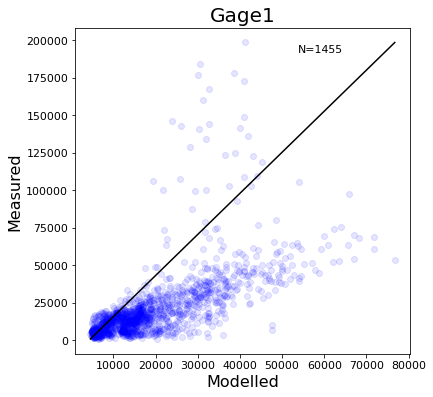

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x = rei_df.loc[rei_df.group == 'gage1'].modelled
y = rei_df.loc[rei_df.group == 'gage1'].measured
plt.scatter(x, y, alpha=0.1, color='blue')
plt.plot([x.min(), x.max()], [y.min(), y.max()], c='k')
ax.annotate(f'N={len(x)}', xy=(10000, 70000),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            )
plt.xlabel('Modelled', fontsize=16)
plt.ylabel('Measured', fontsize=16)
plt.title('Gage1', fontsize=20)

Text(0.5, 1.0, 'Gage2')

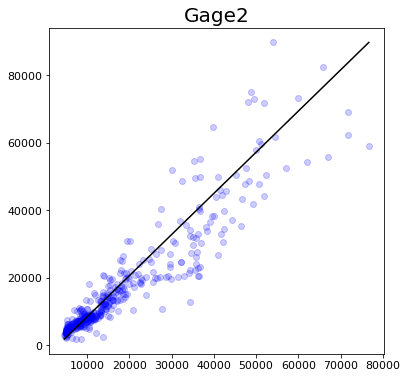

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x = rei_df.loc[rei_df.group == 'gage2'].modelled
y = rei_df.loc[rei_df.group == 'gage2'].measured
plt.scatter(x, y, alpha=0.2, color='blue')
plt.plot([x.min(), x.max()], [y.min(), y.max()], c='k')
plt.title('Gage2', fontsize=20)

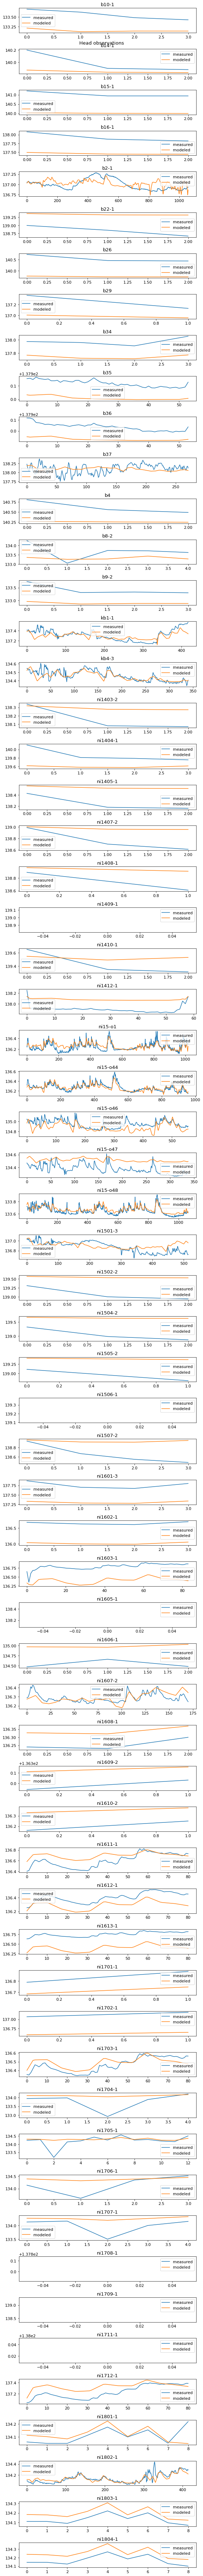

In [25]:
nsubplots = len(heads_sites)

fig, axs = plt.subplots(nsubplots, 1, figsize=(8, 100))
for i, site in enumerate(heads_sites):
    if 'lk' not in site:
        x = [i for i in range(len(rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads')]))]
        y_meas = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads')]['measured']
        y_comp = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads')]['modelled']
        
        axs[i].plot(x, y_meas, label='measured')
        axs[i].plot(x, y_comp, label='modeled')
        axs[i].set_title(site)
        axs[i].legend()

plt.suptitle('Head observations')
plt.tight_layout()

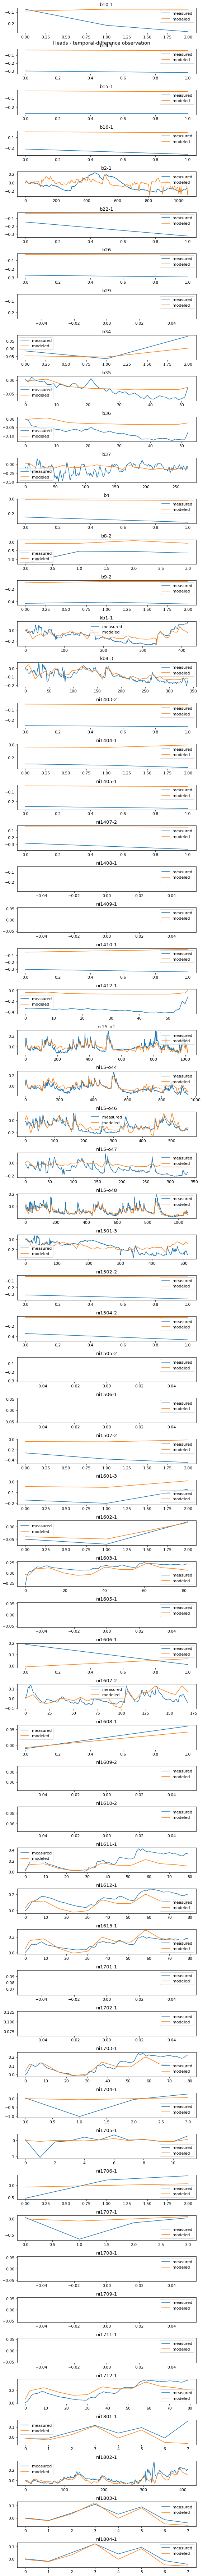

In [26]:
nsubplots = len(heads_sites)

fig, axs = plt.subplots(nsubplots, 1, figsize=(8, 100))
for i, site in enumerate(heads_sites):
    if 'lk' not in site:
        x = [i for i in range(len(rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads_d')]))]
        y_meas = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads_d')]['measured']
        y_comp = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'heads_d')]['modelled']
        
        axs[i].plot(x, y_meas, label='measured')
        axs[i].plot(x, y_comp, label='modeled')
        axs[i].set_title(site)
        axs[i].legend()

plt.suptitle('Heads - temporal-difference observation')
plt.tight_layout()

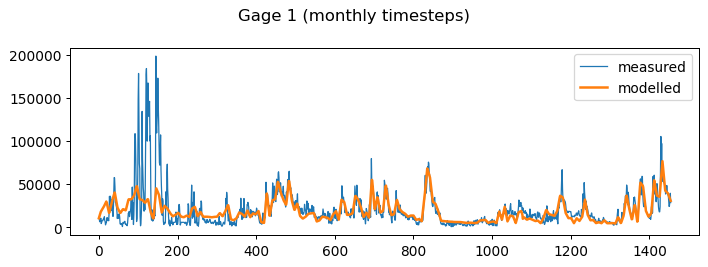

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=90)
x = [i for i in range(len(rei_df.loc[rei_df['group'] == 'gage1']))]
y_meas = rei_df.loc[rei_df['group'] == 'gage1']['measured']
y_comp = rei_df.loc[rei_df['group'] == 'gage1']['modelled']
plt.plot(x, y_meas, label='measured', lw=1)
plt.plot(x, y_comp, label='modelled', lw=2)

plt.legend()
plt.suptitle('Gage 1 (monthly timesteps)')
plt.tight_layout()
plt.show()

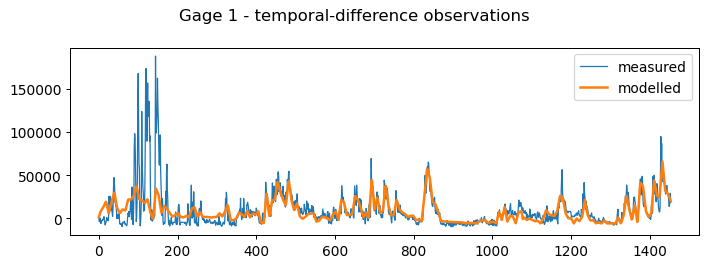

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=90)
x = [i for i in range(len(rei_df.loc[rei_df['group'] == 'gage1_d']))]
y_meas = rei_df.loc[rei_df['group'] == 'gage1_d']['measured']
y_comp = rei_df.loc[rei_df['group'] == 'gage1_d']['modelled']
plt.plot(x, y_meas, label='measured', lw=1)
plt.plot(x, y_comp, label='modelled', lw=2)

plt.legend()
plt.suptitle('Gage 1 - temporal-difference observations')
plt.tight_layout()
plt.show()

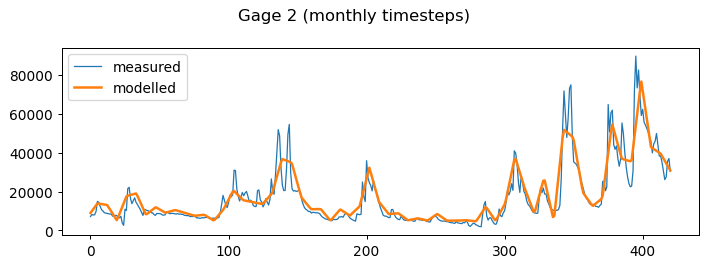

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=90)
x = [i for i in range(len(rei_df.loc[rei_df['group'] == 'gage2']))]
y_meas = rei_df.loc[rei_df['group'] == 'gage2']['measured']
y_comp = rei_df.loc[rei_df['group'] == 'gage2']['modelled']
plt.plot(x, y_meas, label='measured', lw=1)
plt.plot(x, y_comp, label='modelled', lw=2)

plt.legend()
plt.suptitle('Gage 2 (monthly timesteps)')
plt.tight_layout()
plt.show()

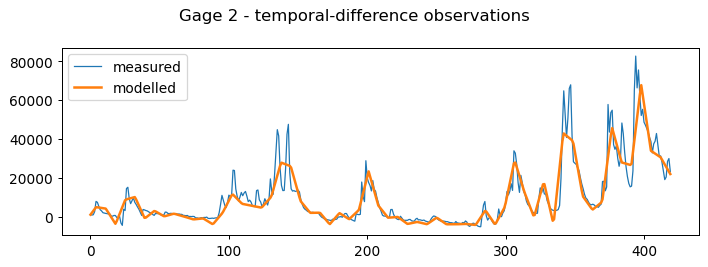

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=90)
x = [i for i in range(len(rei_df.loc[rei_df['group'] == 'gage2_d']))]
y_meas = rei_df.loc[rei_df['group'] == 'gage2_d']['measured']
y_comp = rei_df.loc[rei_df['group'] == 'gage2_d']['modelled']
plt.plot(x, y_meas, label='measured', lw=1)
plt.plot(x, y_comp, label='modelled', lw=2)

plt.legend()
plt.suptitle('Gage 2 - temporal-difference observations')
plt.tight_layout()
plt.show()

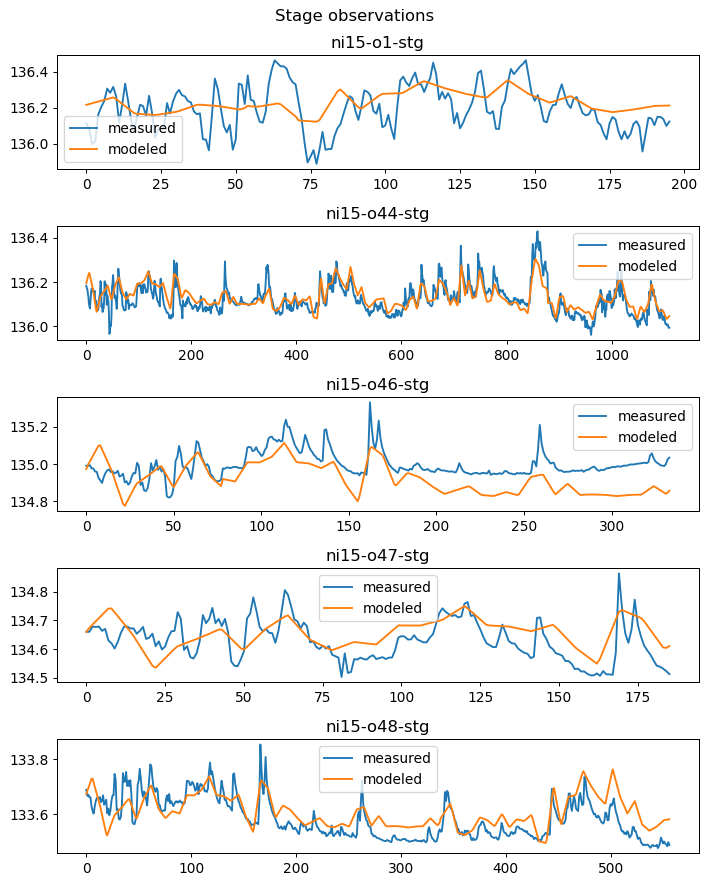

In [31]:
nsubplots = len(stage1_sites)

fig, axs = plt.subplots(nsubplots, 1, figsize=(8, 10), dpi=90)
for i, site in enumerate(stage1_sites):
    if 'lk' not in site:
        x = [i for i in range(len(rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1')]))]
        y_meas = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1')]['measured']
        y_comp = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1')]['modelled']
        
        axs[i].plot(x, y_meas, label='measured')
        axs[i].plot(x, y_comp, label='modeled')
        axs[i].set_title(site)
        axs[i].legend()

plt.suptitle('Stage observations')
plt.tight_layout()

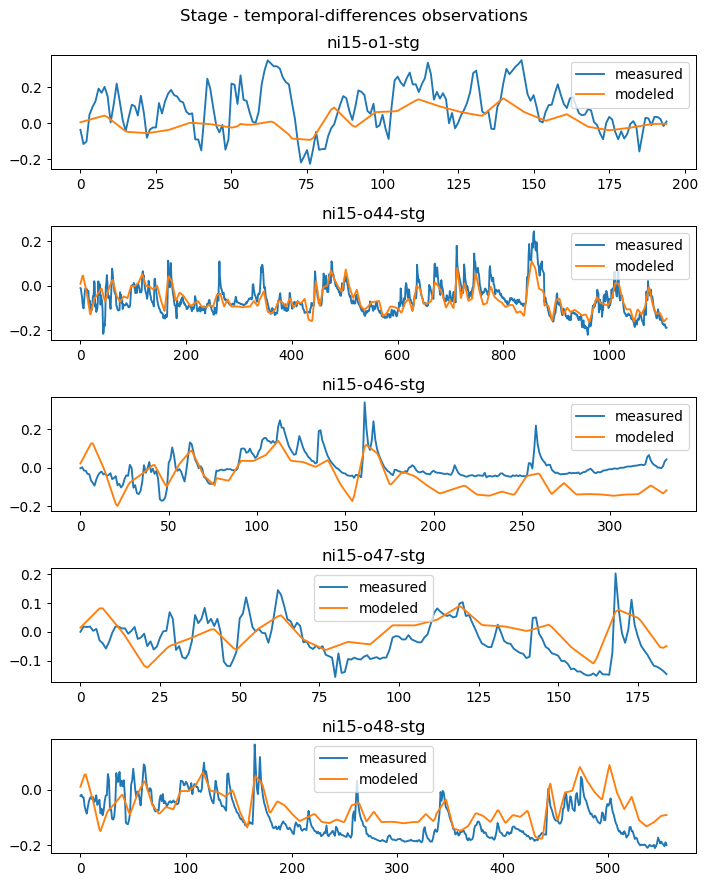

In [32]:
nsubplots = len(stage1_sites)

fig, axs = plt.subplots(nsubplots, 1, figsize=(8, 10), dpi=90)
for i, site in enumerate(stage1_sites):
    if 'lk' not in site:
        x = [i for i in range(len(rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1_d')]))]
        y_meas = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1_d')]['measured']
        y_comp = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'stage1_d')]['modelled']
        
        axs[i].plot(x, y_meas, label='measured')
        axs[i].plot(x, y_comp, label='modeled')
        axs[i].set_title(site)
        axs[i].legend()

plt.suptitle('Stage - temporal-differences observations')
plt.tight_layout()

In [33]:
rei_df.loc[rei_df['group'] == 'dh_hedstg']['measured']

12192    0.134576
12193    0.162344
12194    0.278417
12195    0.310944
12196    0.237284
           ...   
14228    0.107450
14229    0.111983
14230    0.108550
14231    0.120067
14232    0.118250
Name: measured, Length: 2041, dtype: float64

In [34]:
dh_hedstg_sites

array(['dh-ni15-o1', 'dh-ni15-o44', 'dh-ni15-o46', 'dh-ni15-o47',
       'dh-ni15-o48'], dtype=object)

In [35]:
rei_df.loc[rei_df['sites'] == 'dh-ni15-o44']

name      group  measured  modelled  residual  weight  \
12388    dh-ni15-o44_1  dh_hedstg  0.173633  0.151154  0.022479  2.7786   
12389    dh-ni15-o44_2  dh_hedstg  0.180250  0.151284  0.028966  2.7786   
12390    dh-ni15-o44_3  dh_hedstg  0.165316  0.151414  0.013902  2.7786   
12391    dh-ni15-o44_4  dh_hedstg  0.168866  0.151950  0.016916  2.7786   
12392    dh-ni15-o44_5  dh_hedstg  0.165900  0.152558  0.013342  2.7786   
...                ...        ...       ...       ...       ...     ...   
13155  dh-ni15-o44_768  dh_hedstg  0.151197  0.122632  0.028565  2.7786   
13156  dh-ni15-o44_769  dh_hedstg  0.150964  0.125856  0.025108  2.7786   
13157  dh-ni15-o44_770  dh_hedstg  0.151131  0.129080  0.022051  2.7786   
13158  dh-ni15-o44_771  dh_hedstg  0.151947  0.132305  0.019642  2.7786   
13159  dh-ni15-o44_772  dh_hedstg  0.154114  0.135529  0.018585  2.7786   

             sites  
12388  dh-ni15-o44  
12389  dh-ni15-o44  
12390  dh-ni15-o44  
12391  dh-ni15-o44  
12392  dh-ni15-o44  
...            ...  
13155  dh-ni15-o44  
13156  dh-ni15-o44  
13157  dh-ni15-o44  
13158  dh-ni15-o44  
13159  dh-ni15-o44  

[772 rows x 7 columns]

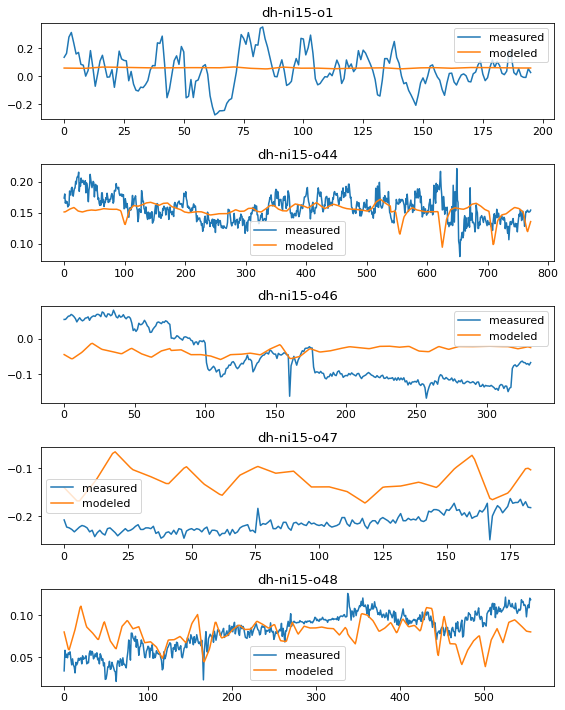

In [36]:
nsubplots = len(dh_hedstg_sites)

fig, axs = plt.subplots(nsubplots, 1, figsize=(8, 10))
for i, site in enumerate(dh_hedstg_sites):
    if 'lk' not in site:
        x = [i for i in range(len(rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'dh_hedstg')]))]
        y_meas = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'dh_hedstg')]['measured']
        y_comp = rei_df.loc[(rei_df['sites'] == site) & (rei_df['group'] == 'dh_hedstg')]['modelled']
        
        axs[i].plot(x, y_meas, label='measured')
        axs[i].plot(x, y_comp, label='modeled')
        axs[i].set_title(site)
        axs[i].legend()

plt.tight_layout()

NameError: name 'gwf_agent' is not defined

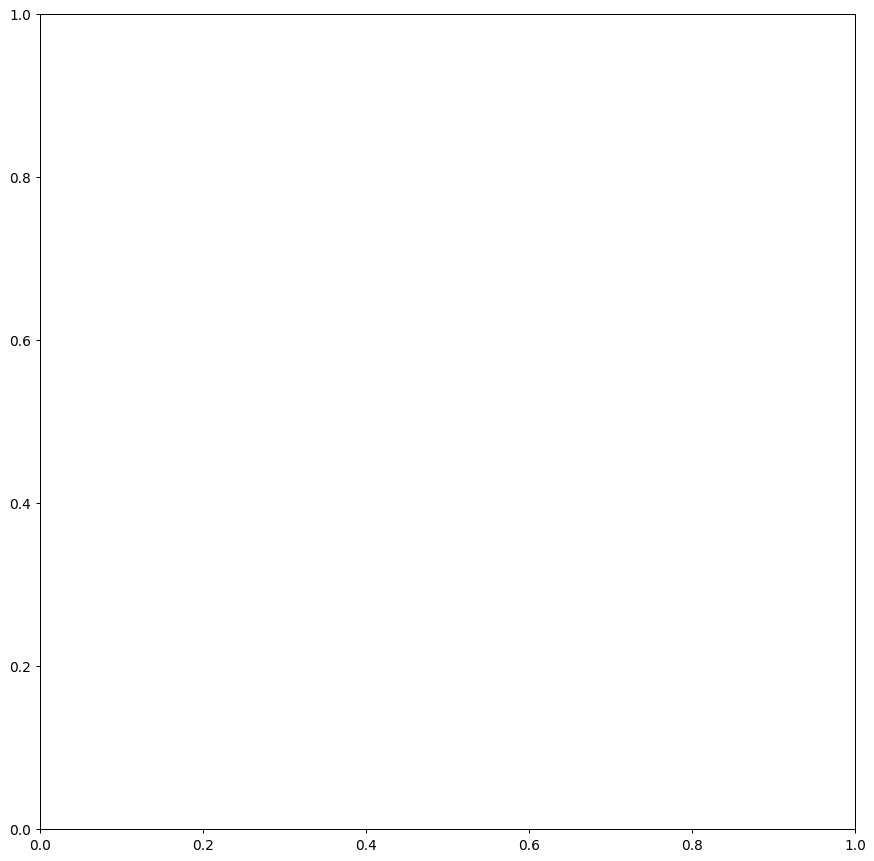

In [37]:
spd = 20

fig = plt.figure(figsize=(12, 12), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25, color='k')
quadmesh = mapview.plot_array(a=hdata[spd], alpha=0.9, masked_values=[1e30])
plt.colorbar(quadmesh, shrink=0.4);

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=25, label=f'{category} measurements')

levels = np.arange(130, 145, 1.0)
contour_set = mapview.contour_array(hdata[spd], levels=levels, colors='white')
plt.clabel(contour_set, fmt="%.1f", colors='white', fontsize=11)


plt.title(f'Heads (spd: {spd})')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 12), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25, color='k')
quadmesh = mapview.plot_array(a=hdata[spd], alpha=0.9, masked_values=[1e30])

quiver = mapview.plot_vector(qx, qy, alpha=0.50)


plt.colorbar(quadmesh, shrink=0.4);

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=25, label=f'{category} measurements')

plt.title("Specific Discharge (" + r"$L/T$" + ")")
plt.legend()
plt.show()

### Hydraulic conductivity:

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25)
gwf_agent.npf.k.plot(masked_values=[0.0], colorbar=True, cmap="viridis", norm=LogNorm())    

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=10, label=f'{category} measurements', c='k')

plt.title('Kh (m/d). Black dots represent measurement locations')
plt.show()

In [64]:
print('Mean of Kh is: ' + str(gwf_agent.npf.k.data.mean()))
print('Median of Kh is: ' + str(np.median(gwf_agent.npf.k.data)))

Mean of Kh is: 232.9621784485224
Median of Kh is: 91.59098128549999


### Storage:

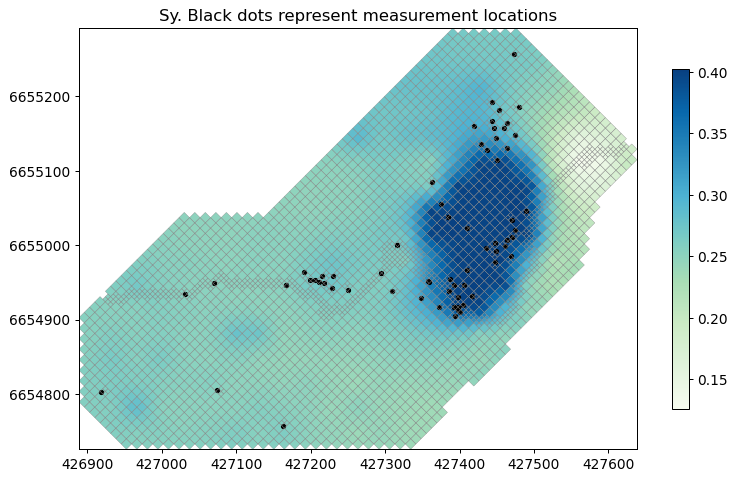

In [65]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Hydraulic Conductivity pilot point locations', fontsize=10)

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25)
gwf_agent.sto.sy.plot(masked_values=[0.0], colorbar=True, cmap="GnBu")

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=10, label=f'{category} measurements', c='k')

plt.title('Sy. Black dots represent measurement locations')

plt.show()

### General head boundary

In [66]:
ghb_spd_df = pd.DataFrame(gwf_agent.ghb.stress_period_data.data[0])
ghb_spd_df['icpl'] = [i[1] for i in gwf_agent.ghb.stress_period_data.data[0].cellid]

In [67]:
ghb_df = pd.DataFrame({'icpl': [i for i in range(gwf_agent.disv.ncpl.array)]})

In [68]:
ghb_arr_df = ghb_df.merge(
    ghb_spd_df[['icpl', 'cond', 'boundname']],
    how='left',
    left_on='icpl',
    right_on='icpl'
).fillna(0)

ghb_arr_df.drop_duplicates(subset='icpl', keep='first', inplace=True, ignore_index=True)

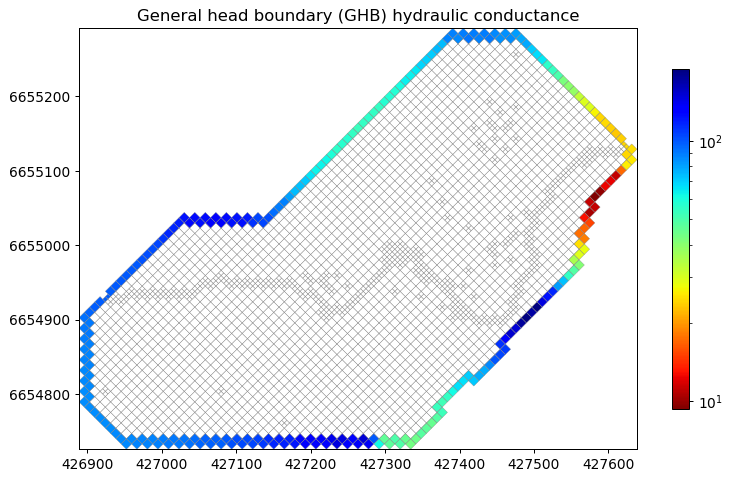

In [69]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0)
quadmesh = mapview.plot_array(ghb_arr_df.cond.values, masked_values=[0.0], cmap='jet_r', norm=LogNorm())
cb = plt.colorbar(quadmesh, shrink=0.5)
linecollection = mapview.plot_grid(lw=0.25)

plt.title('General head boundary (GHB) hydraulic conductance')
plt.show()

In [70]:
with open(os.path.join(agent_ml, 'ghb_new.ts'), 'r') as file:
    ghb_ts = file.readlines()

In [71]:
ghb_ts_start = next(i for i, w in enumerate(ghb_ts) if 'BEGIN TIMESERIES' in w) + 1
ghb_ts_end = next(i for i, w in enumerate(ghb_ts) if 'END TIMESERIES' in w)
ghb_ts_data = [i.split() for i in ghb_ts[ghb_ts_start:ghb_ts_end]]
ghb_ts_cols = ['time', 'red', 'yellow', 'green', 'blue']

In [72]:
ghb_ts_df = pd.DataFrame(ghb_ts_data, columns=ghb_ts_cols)
ghb_ts_df = ghb_ts_df.astype(float)

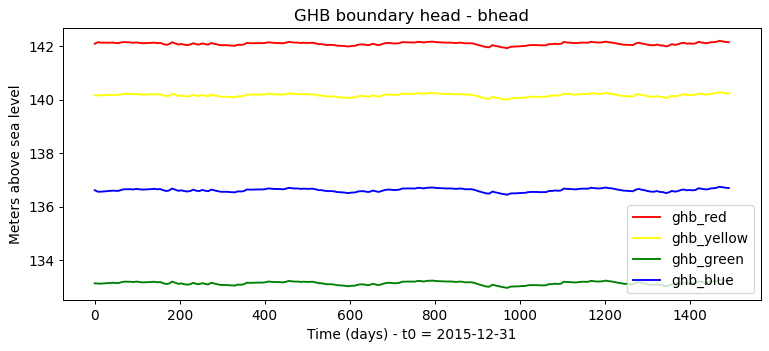

In [73]:
fig = plt.figure(figsize=(10, 4), dpi=90)
ghb_ts_x = ghb_ts_df['time']
for bname in ghb_ts_df.iloc[:, 1:].columns:
    ghb_ts_y = ghb_ts_df[bname]
    plt.plot(ghb_ts_x, ghb_ts_y, color=bname, label=f'ghb_{bname}')
plt.legend()
plt.xlabel('Time (days) - t0 = 2015-12-31')
plt.ylabel('Meters above sea level')
plt.title('GHB boundary head - bhead')
plt.show()

In [74]:
ghb_ts_df.describe()

time         red      yellow       green        blue
count   213.000000  213.000000  213.000000  213.000000  213.000000
mean    745.511737  142.101930  140.172357  133.129961  136.616790
std     433.717798    0.053063    0.054868    0.061495    0.060321
min       0.000000  141.938000  140.004300  132.955800  136.445300
25%     373.000000  142.062800  140.133000  133.086600  136.573800
50%     746.000000  142.117400  140.184600  133.135300  136.623900
75%    1119.000000  142.144000  140.216100  133.185100  136.666200
max    1492.000000  142.212500  140.290600  133.257400  136.746000

In [75]:
ghb_arr_df

icpl        cond boundname
0        0   92.997283     green
1        1   96.382930      blue
2        2   98.819773      blue
3        3   98.631033      blue
4        4   98.461748      blue
...    ...         ...       ...
3035  3035   78.434749    yellow
3036  3036   86.458020    yellow
3037  3037  101.068038    yellow
3038  3038  106.692789    yellow
3039  3039  109.941066    yellow

[3040 rows x 3 columns]

### Recharge

In [76]:
with open(os.path.join(agent_ml, 'rch_new.ts'), 'r') as file:
    rch_ts = file.readlines()

In [77]:
rch_ts_start = next(i for i, w in enumerate(rch_ts) if 'BEGIN TIMESERIES' in w) + 1
rch_ts_end = next(i for i, w in enumerate(rch_ts) if 'END TIMESERIES' in w)
rch_ts_data = [i.split() for i in rch_ts[rch_ts_start:rch_ts_end]]
rch_ts_cols = ['time', 'rch_lu1']

In [78]:
rch_ts_df = pd.DataFrame(rch_ts_data, columns=rch_ts_cols)
rch_ts_df = rch_ts_df.astype(float)

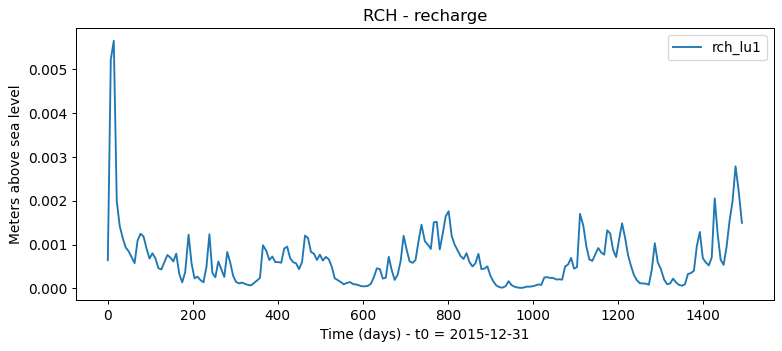

In [79]:
fig = plt.figure(figsize=(10, 4), dpi=90)
rch_ts_x = rch_ts_df['time']
for bname in rch_ts_df.iloc[:, 1:].columns:
    rch_ts_y = rch_ts_df[bname]
    plt.plot(rch_ts_x, rch_ts_y, label=bname)
plt.legend()
plt.xlabel('Time (days) - t0 = 2015-12-31')
plt.ylabel('Meters above sea level')
plt.title('RCH - recharge')
plt.show()

In [80]:
rch_spd_df = pd.DataFrame(gwf_agent.rch.stress_period_data.data[0])
rch_spd_df['icpl'] = [i[1] for i in gwf_agent.rch.stress_period_data.data[0].cellid]

In [81]:
rch_df = pd.DataFrame({'icpl': [i for i in range(gwf_agent.disv.ncpl.array)]})

In [82]:
rch_arr_df = rch_df.merge(
    rch_spd_df[['icpl', 'multiplier']],
    how='left',
    left_on='icpl',
    right_on='icpl'
).fillna(0)

rch_arr_df.drop_duplicates(subset='icpl', keep='first', inplace=True, ignore_index=True)

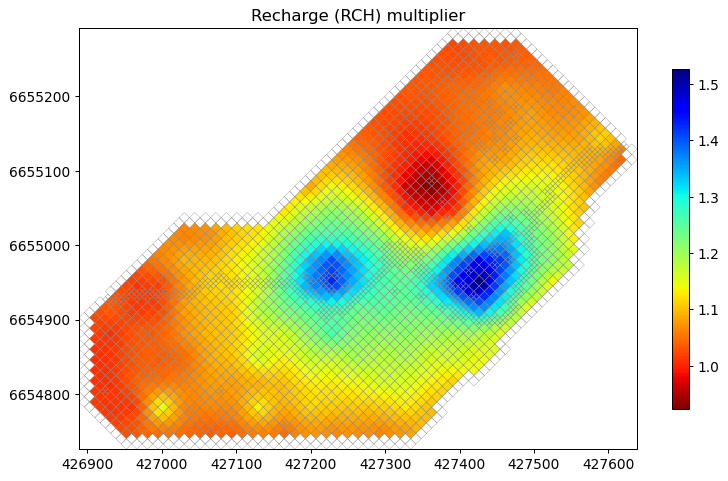

In [83]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0)
quadmesh = mapview.plot_array(rch_arr_df.multiplier.values, masked_values=[0.0], cmap='jet_r')
cb = plt.colorbar(quadmesh, shrink=0.5)
linecollection = mapview.plot_grid(lw=0.25)

plt.title('Recharge (RCH) multiplier')
plt.show()

### Streamflow routing

In [84]:
sfr_pkgdata_df = pd.DataFrame(gwf_agent.sfr.packagedata.array)
sfr_pkgdata_df['icpl'] = [i[1] for i in gwf_agent.sfr.packagedata.array.cellid]

In [85]:
sfr_df = pd.DataFrame({'icpl': [i for i in range(gwf_agent.disv.ncpl.array)]})

In [86]:
sfr_arr_df = sfr_df.merge(
    sfr_pkgdata_df[['icpl', 'rno', 'rwid', 'rtp', 'rgrd', 'rbth', 'rhk', 'man']],
    how='left',
    left_on='icpl',
    right_on='icpl'
).fillna(0)

sfr_arr_df['man'] = sfr_arr_df['man'].astype(float)

In [87]:
sfr_df['pred'] = np.zeros_like(sfr_df)

<ipython-input-88-8f25500da4e0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfr_df.iloc[pred1_x.index[0]]['pred'] = 1
<ipython-input-88-8f25500da4e0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfr_df.iloc[pred2_x.index[0]]['pred'] = 2
<ipython-input-88-8f25500da4e0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfr_df.iloc[pred3_x.index[0]]['pred'] = 3


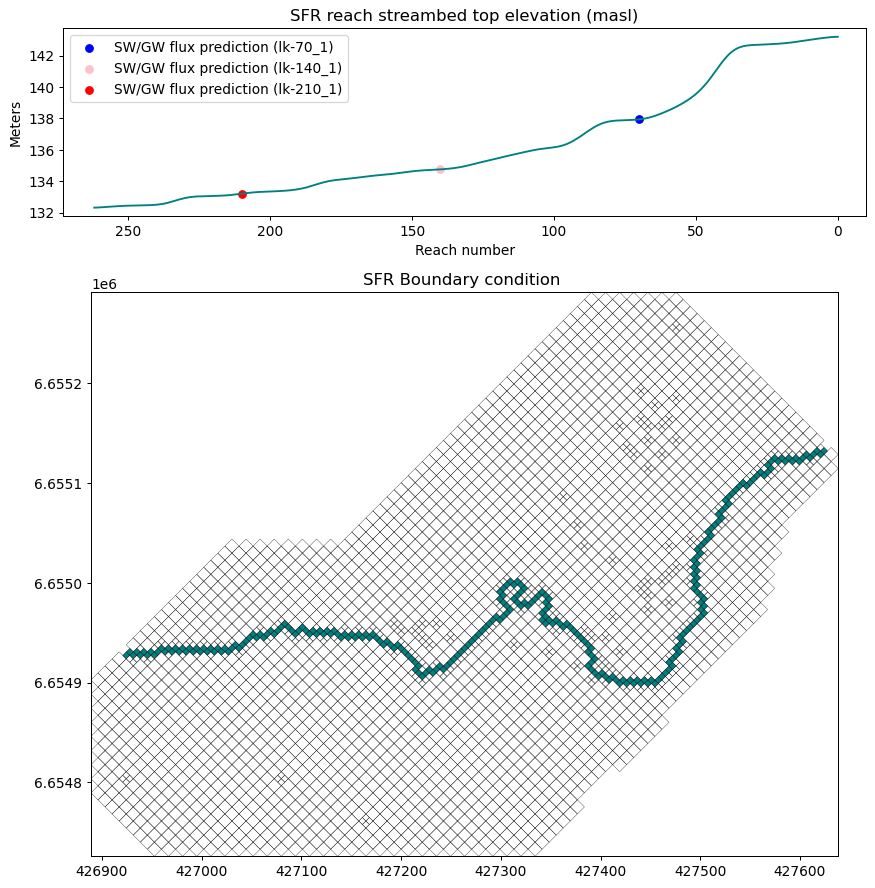

In [88]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), dpi=90, gridspec_kw={'height_ratios': [1, 3]})

pred1_x, pred1_y = sfr_arr_df.loc[sfr_arr_df['rno'] == 70]['rno'], sfr_arr_df.loc[sfr_arr_df['rno'] == 70]['rtp']
pred2_x, pred2_y = sfr_arr_df.loc[sfr_arr_df['rno'] == 140]['rno'], sfr_arr_df.loc[sfr_arr_df['rno'] == 140]['rtp']
pred3_x, pred3_y = sfr_arr_df.loc[sfr_arr_df['rno'] == 210]['rno'], sfr_arr_df.loc[sfr_arr_df['rno'] == 210]['rtp']

sfr_df.iloc[pred1_x.index[0]]['pred'] = 1
sfr_df.iloc[pred2_x.index[0]]['pred'] = 2
sfr_df.iloc[pred3_x.index[0]]['pred'] = 3

axs[0].set_title('SFR reach streambed top elevation (masl)')
axs[0].set_ylabel('Meters')
axs[0].set_xlabel('Reach number')

axs[0].plot(sfr_pkgdata_df.rtp, color='teal')
axs[0].set_xlim(len(sfr_pkgdata_df) + 10, -10)

axs[0].scatter(pred1_x, pred1_y, c='b', label='SW/GW flux prediction (lk-70_1)')
axs[0].scatter(pred2_x, pred2_y, color='pink', label='SW/GW flux prediction (lk-140_1)')
axs[0].scatter(pred3_x, pred3_y, c='r', label='SW/GW flux prediction (lk-210_1)')
axs[0].legend()

axs[1].set_aspect('equal')
axs[1].set_title('SFR Boundary condition ')
mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0, ax=axs[1])
linecollection = mapview.plot_grid(lw=0.25, color='k', ax=axs[1])
bc = mapview.plot_bc('SFR', ax=axs[1])
quadmesh = mapview.plot_array(sfr_df.pred, masked_values=[0.0], cmap="bwr", norm=LogNorm())

plt.tight_layout()
plt.show()

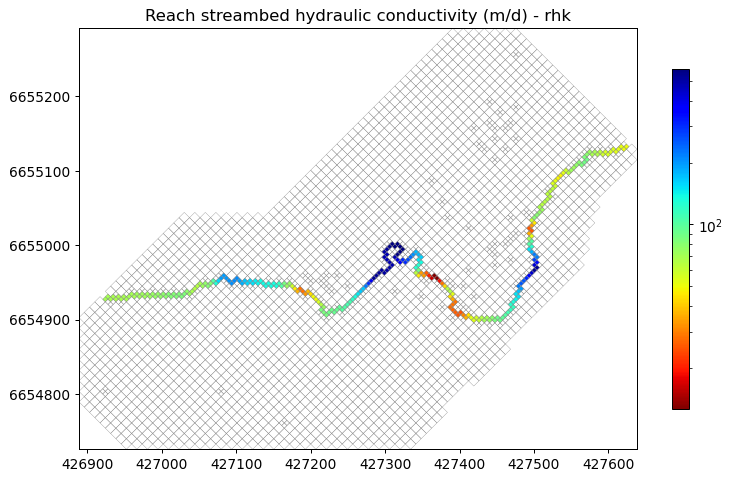

In [89]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0)
quadmesh = mapview.plot_array(sfr_arr_df.rhk.values, masked_values=[0.0], cmap='jet_r', norm=LogNorm())
cb = plt.colorbar(quadmesh, shrink=0.5)
linecollection = mapview.plot_grid(lw=0.25)

plt.title('Reach streambed hydraulic conductivity (m/d) - rhk')
plt.show()

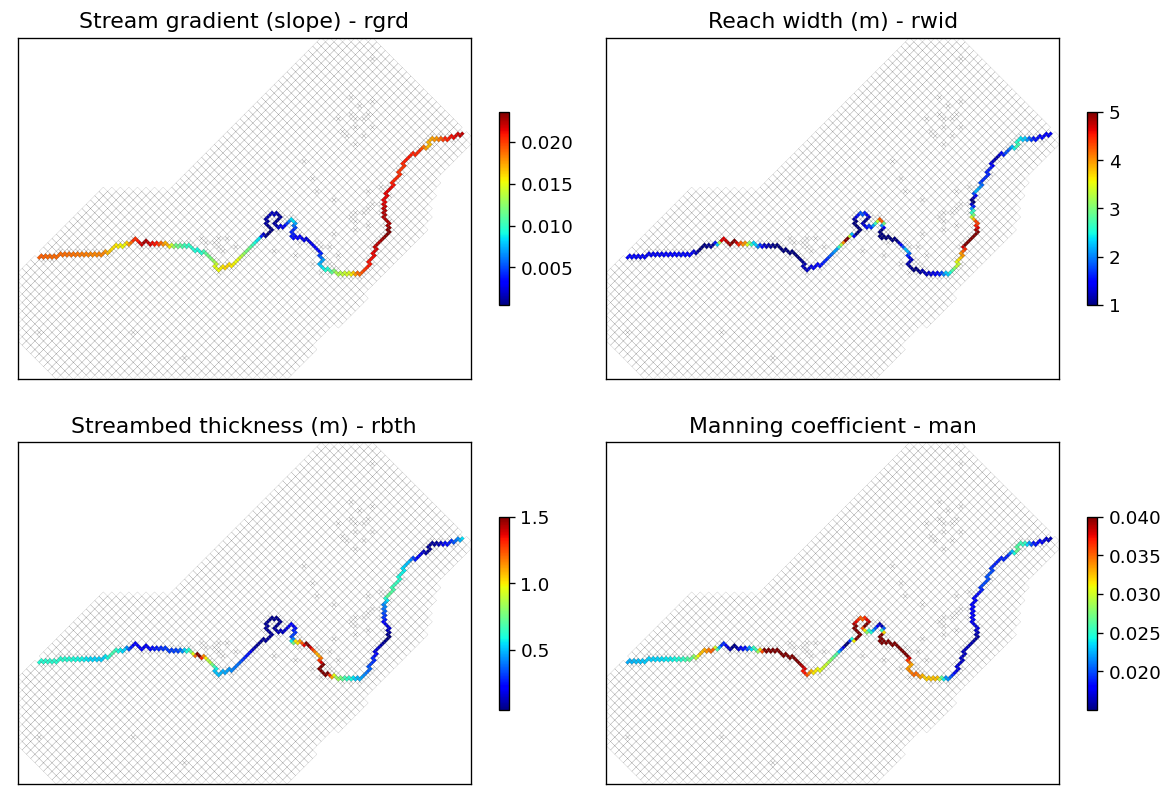

In [90]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7), dpi=120)

axs[0, 0].set_title('Stream gradient (slope) - rgrd')
mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0, ax=axs[0, 0])
quadmesh = mapview.plot_array(sfr_arr_df.rgrd.values, masked_values=[0.0], cmap='jet', ax=axs[0, 0])
cb = plt.colorbar(quadmesh, shrink=0.5, ax=axs[0, 0])

axs[0, 1].set_title('Reach width (m) - rwid')
mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0, ax=axs[0, 1])
quadmesh = mapview.plot_array(sfr_arr_df.rwid.values, masked_values=[0.0], cmap='jet', ax=axs[0, 1])
cb = plt.colorbar(quadmesh, shrink=0.5, ax=axs[0, 1])

axs[1, 0].set_title('Streambed thickness (m) - rbth')
mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0, ax=axs[1, 0])
quadmesh = mapview.plot_array(sfr_arr_df.rbth.values, masked_values=[0.0], cmap='jet', ax=axs[1, 0])
cb = plt.colorbar(quadmesh, shrink=0.5, ax=axs[1, 0])

axs[1, 1].set_title('Manning coefficient - man')
mapview = flopy.plot.PlotMapView(model=gwf_agent, layer=0, ax=axs[1, 1])
quadmesh = mapview.plot_array(sfr_arr_df.man.values, masked_values=[0.0], cmap='jet', ax=axs[1, 1])
cb = plt.colorbar(quadmesh, shrink=0.5, ax=axs[1, 1])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set_aspect('equal')
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.label_outer()
    linecollection = mapview.plot_grid(lw=0.05, color='k', ax=ax)
    
plt.tight_layout()

## SW/GW exchange

In [91]:
swgwdf = pd.read_csv(os.path.join(agent_ml, 'sfr_pred_flux.obs.csv'))
swgwdf.head()

time  FLUX-BOUND1   FLUX-BOUND2   FLUX-BOUND3   FLUX-BOUND4  \
0   0.000000  2324.885273  10336.533380  11110.376060 -18892.121040   
1   7.033019  2729.205728   7248.879835      0.233843  -7175.688698   
2  14.066038  2363.939392   9263.080334   9795.082883 -16486.052100   
3  21.099057  4261.612252   2508.431014      0.096316  -4270.916591   
4  28.132075   635.102863      0.099360      0.125881    -47.294228   

   FLUX-BOUND5  FLUX-BOUND6  FLUX-BOUND7  FLUX-BOUND8  FLUX-BOUND9  \
0  -993.073049  -512.751692   325.709479 -3201.097455  -266.761877   
1  -937.590247  -817.860045   -13.049715 -2795.289087  -636.429629   
2 -1048.038094  -717.140031   100.021892 -2949.457404  -458.484892   
3  -806.511942  -756.639424   -11.648464 -2658.958022  -528.700371   
4  -393.557054  -704.765747   -37.572317 -2404.740767  -468.948229   

   FLUX-BOUND10  FLUX-BOUND11  FLUX-BOUND12  FLUX-BOUND13  FLUX-BOUND14  
0    365.644283     53.702528  -7819.443845    -51.735713  -3884.942058  
1     20.317738   -570.366401  -7246.328677   -301.052076  -4149.170861  
2    162.298382   -351.640084  -7334.211166   -213.579633  -4024.255867  
3     83.147685   -570.293213  -6985.944684   -283.937385  -4084.317818  
4     83.750894   -635.904510  -6798.169357   -299.284206  -4099.446700

In [92]:
# long form
swgwdf_lf = swgwdf.melt(id_vars=['time'])
swgwdf_lf['value_norm'] = np.zeros_like(len(swgwdf_lf))
swgwdf_lf['bound_comp'] = swgwdf_lf.variable
swgwdf_lf

time      variable        value  value_norm    bound_comp
0        0.000000   FLUX-BOUND1  2324.885273           0   FLUX-BOUND1
1        7.033019   FLUX-BOUND1  2729.205728           0   FLUX-BOUND1
2       14.066038   FLUX-BOUND1  2363.939392           0   FLUX-BOUND1
3       21.099057   FLUX-BOUND1  4261.612252           0   FLUX-BOUND1
4       28.132075   FLUX-BOUND1   635.102863           0   FLUX-BOUND1
...           ...           ...          ...         ...           ...
2977  1462.867925  FLUX-BOUND14 -4172.698106           0  FLUX-BOUND14
2978  1469.900943  FLUX-BOUND14 -4029.207411           0  FLUX-BOUND14
2979  1476.933962  FLUX-BOUND14 -4199.930208           0  FLUX-BOUND14
2980  1483.966981  FLUX-BOUND14 -4160.952899           0  FLUX-BOUND14
2981  1491.000000  FLUX-BOUND14 -4172.830079           0  FLUX-BOUND14

[2982 rows x 5 columns]

In [93]:
len(swgwdf_lf)

2982

In [94]:
sfr_pkg = gwf_agent.get_package('sfr')
sfr_pkg_df = pd.DataFrame(sfr_pkg.packagedata.array)
sfr_pkg_df['reach_m2'] = sfr_pkg_df.rlen * sfr_pkg_df.rwid
sfr_pkg_df['bound_comp'] = ['FLUX-BOUND'+i[5:] for i in sfr_pkg_df.boundname]
sfr_pkg_df.head()

rno     cellid  rlen      rwid      rgrd         rtp      rbth        rhk  \
0    0  (0, 2645)  5.88  1.408046  0.022317  143.200861  0.551276  50.163560   
1    1  (0, 2643)  1.85  1.430909  0.022091  143.193699  0.490876  50.993497   
2    2  (0, 2641)  3.56  1.454147  0.021867  143.181910  0.437086  51.837302   
3    3  (0, 2640)  5.53  1.477772  0.021646  143.166145  0.389171  52.695426   
4    4  (0, 2637)  2.84  1.501751  0.021427  143.147210  0.346559  53.566629   

               man  ncon  ustrf  ndv boundname  reach_m2   bound_comp  
0  1.622378400e-02     1    1.0    0    bound1  8.279310  FLUX-BOUND1  
1  1.654599776e-02     2    1.0    0    bound1  2.647182  FLUX-BOUND1  
2  1.687465140e-02     2    1.0    0    bound1  5.176764  FLUX-BOUND1  
3  1.720998110e-02     2    1.0    0    bound1  8.172081  FLUX-BOUND1  
4  1.755153702e-02     2    1.0    0    bound1  4.264972  FLUX-BOUND1

In [95]:
for i,r in sfr_pkg_df.iterrows():
    swgwdf_lf.loc[swgwdf_lf.variable == r.bound_comp, 'value_norm'] = swgwdf_lf.loc[swgwdf_lf.variable == r.bound_comp].value / r.reach_m2

In [96]:
# SW/GW exchange flow is now normalized per square meter in value_norm
swgwdf_lf.head()

time     variable        value  value_norm   bound_comp
0   0.000000  FLUX-BOUND1  2324.885273  176.252166  FLUX-BOUND1
1   7.033019  FLUX-BOUND1  2729.205728  206.904154  FLUX-BOUND1
2  14.066038  FLUX-BOUND1  2363.939392  179.212902  FLUX-BOUND1
3  21.099057  FLUX-BOUND1  4261.612252  323.077615  FLUX-BOUND1
4  28.132075  FLUX-BOUND1   635.102863   48.147862  FLUX-BOUND1

In [97]:
mean_norm_val = []
for i in swgwdf_lf.variable.unique():
    mean_norm = swgwdf_lf.loc[swgwdf_lf.variable == i].value_norm.mean()
    mean_norm_val.append(mean_norm)

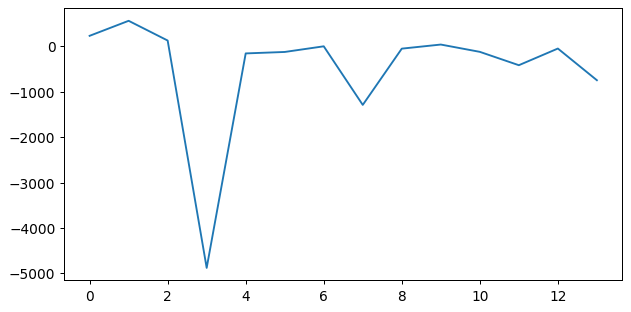

In [98]:
fig = plt.figure(figsize=(8, 4), dpi=90)
ax = fig.add_subplot(1, 1, 1)
plt.plot(mean_norm_val)

Text(0.5, 1.0, 'SW/GW exchange flux (m3/day), negative values = loss from gw to sfr')

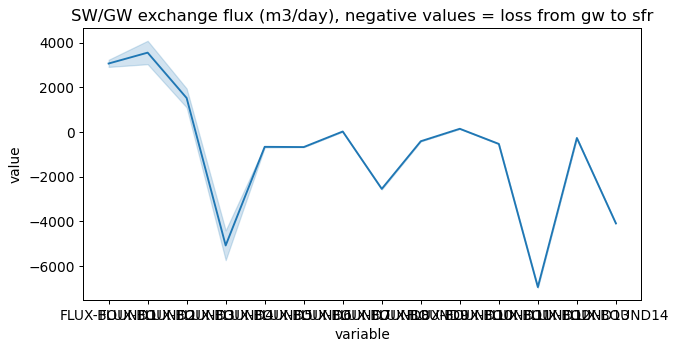

In [99]:
import seaborn as sns
plt.figure(figsize=(8, 4), dpi=90)
sns.lineplot(data=swgwdf_lf, x = 'variable', y='value')
plt.title('SW/GW exchange flux (m3/day), negative values = loss from gw to sfr')

Text(0.5, 1.0, 'Normalized SW/GW exchange flux (m3/day/m2),\nnegative values = loss from gw to sfr')

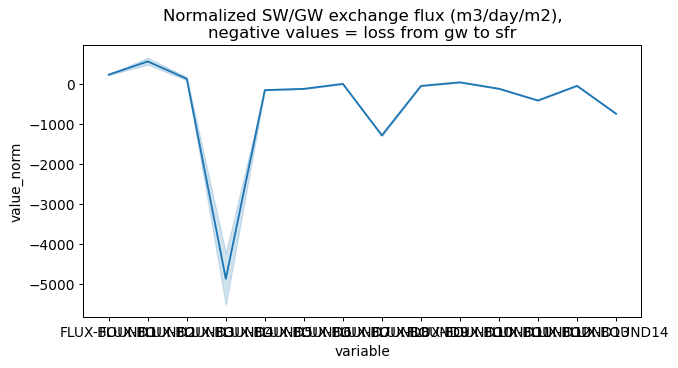

In [100]:
plt.figure(figsize=(8, 4), dpi=90)
sns.lineplot(data=swgwdf_lf, x = 'variable', y='value_norm')
plt.title('Normalized SW/GW exchange flux (m3/day/m2),\nnegative values = loss from gw to sfr')

In [101]:
sfr_pkg_df

rno     cellid  rlen      rwid      rgrd         rtp      rbth  \
0      0  (0, 2645)  5.88  1.408046  0.022317  143.200861  0.551276   
1      1  (0, 2643)  1.85  1.430909  0.022091  143.193699  0.490876   
2      2  (0, 2641)  3.56  1.454147  0.021867  143.181910  0.437086   
3      3  (0, 2640)  5.53  1.477772  0.021646  143.166145  0.389171   
4      4  (0, 2637)  2.84  1.501751  0.021427  143.147210  0.346559   
..   ...        ...   ...       ...       ...         ...       ...   
258  258    (0, 32)  2.07  1.436107  0.018987  132.355642  0.625944   
259  259    (0, 30)  4.10  1.450229  0.019047  132.343445  0.623109   
260  260    (0, 27)  3.67  1.464516  0.019107  132.333243  0.620281   
261  261     (0, 5)  3.41  1.478917  0.019167  132.325490  0.617471   
262  262     (0, 4)  3.67  1.493474  0.019227  132.320463  0.614671   

           rhk              man  ncon  ustrf  ndv boundname  reach_m2  \
0    50.163560  1.622378400e-02     1    1.0    0    bound1  8.279310   
1    50.993497  1.654599776e-02     2    1.0    0    bound1  2.647182   
2    51.837302  1.687465140e-02     2    1.0    0    bound1  5.176764   
3    52.695426  1.720998110e-02     2    1.0    0    bound1  8.172081   
4    53.566629  1.755153702e-02     2    1.0    0    bound1  4.264972   
..         ...              ...   ...    ...  ...       ...       ...   
258  68.935915  2.289686582e-02     2    1.0    0   bound14  2.972741   
259  69.340882  2.276291325e-02     2    1.0    0   bound14  5.945937   
260  69.749043  2.262948139e-02     2    1.0    0   bound14  5.374772   
261  70.158824  2.249708222e-02     2    1.0    0   bound14  5.043106   
262  70.571429  2.236532572e-02     1    1.0    0   bound14  5.481049   

       bound_comp  
0     FLUX-BOUND1  
1     FLUX-BOUND1  
2     FLUX-BOUND1  
3     FLUX-BOUND1  
4     FLUX-BOUND1  
..            ...  
258  FLUX-BOUND14  
259  FLUX-BOUND14  
260  FLUX-BOUND14  
261  FLUX-BOUND14  
262  FLUX-BOUND14  

[263 rows x 15 columns]

In [102]:
import seaborn as sns
plt.figure(figsize=(8, 4), dpi=90)
sns.lineplot(data=swgwdf_lf, x = 'rno', y='value')
plt.title('SW/GW exchange flux (m3/day), negative values = loss from gw to sfr')


bound1_x = [i for i in range(16)]
bound1_y = [0 for i in range(len(bound1_x))]

bound2_x = [i for i in range(16, 32)]
bound2_y = [0 for i in range(len(bound2_x))]

bound3_x = [i for i in range(32, 52)]
bound3_y = [0 for i in range(len(bound3_x))]

bound4_x = [i for i in range(52, 70)]
bound4_y = [0 for i in range(len(bound4_x))]

bound5_x = [i for i in range(70, 102)]
bound5_y = [0 for i in range(len(bound5_x))]

bound6_x = [i for i in range(102, 118)]
bound6_y = [0 for i in range(len(bound6_x))]

bound7_x = [i for i in range(118, 127)]
bound7_y = [0 for i in range(len(bound7_x))]

bound8_x = [i for i in range(127, 140)]
bound8_y = [0 for i in range(len(bound8_x))]

bound9_x = [i for i in range(140, 168)]
bound9_y = [0 for i in range(len(bound9_x))]

bound10_x = [i for i in range(168, 189)]
bound10_y = [0 for i in range(len(bound10_x))]

bound11_x = [i for i in range(189, 200)]
bound11_y = [0 for i in range(len(bound11_x))]

bound12_x = [i for i in range(200, 220)]
bound12_y = [0 for i in range(len(bound12_x))]

bound13_x = [i for i in range(220, 235)]
bound13_y = [0 for i in range(len(bound13_x))]

bound14_x = [i for i in range(235, 263)]
bound14_y = [0 for i in range(len(bound14_x))]

plt.plot(bound1_x, bound1_y, label='bound1', lw=2)
plt.plot(bound2_x, bound2_y, label='bound2', lw=2)
plt.plot(bound3_x, bound3_y, label='bound3', lw=2)
plt.plot(bound4_x, bound4_y, label='bound4', lw=2)
plt.plot(bound5_x, bound5_y, label='bound5', lw=2)
plt.plot(bound6_x, bound6_y, label='bound6', lw=2)
plt.plot(bound7_x, bound7_y, label='bound7', lw=2)
plt.plot(bound8_x, bound8_y, label='bound8', lw=2)
plt.plot(bound9_x, bound9_y, label='bound9', lw=2)
plt.plot(bound10_x, bound10_y, label='bound10', lw=2)
plt.plot(bound11_x, bound11_y, label='bound11', lw=2)
plt.plot(bound12_x, bound12_y, label='bound12', lw=2)
plt.plot(bound13_x, bound13_y, label='bound13', lw=2)
plt.plot(bound14_x, bound14_y, label='bound14', lw=2)

ValueError: Could not interpret value `rno` for parameter `x`

<Figure size 720x360 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 4), dpi=90)
sns.lineplot(data=swgwdf_lf, x = 'rno', y='value_norm')
plt.title('Normalized SW/GW exchange flux (m3/day/m2),\nnegative values = loss from gw to sfr')

bound1_x = [i for i in range(16)]
bound1_y = [0 for i in range(len(bound1_x))]

bound2_x = [i for i in range(16, 32)]
bound2_y = [0 for i in range(len(bound2_x))]

bound3_x = [i for i in range(32, 52)]
bound3_y = [0 for i in range(len(bound3_x))]

bound4_x = [i for i in range(52, 70)]
bound4_y = [0 for i in range(len(bound4_x))]

bound5_x = [i for i in range(70, 102)]
bound5_y = [0 for i in range(len(bound5_x))]

bound6_x = [i for i in range(102, 118)]
bound6_y = [0 for i in range(len(bound6_x))]

bound7_x = [i for i in range(118, 127)]
bound7_y = [0 for i in range(len(bound7_x))]

bound8_x = [i for i in range(127, 140)]
bound8_y = [0 for i in range(len(bound8_x))]

bound9_x = [i for i in range(140, 168)]
bound9_y = [0 for i in range(len(bound9_x))]

bound10_x = [i for i in range(168, 189)]
bound10_y = [0 for i in range(len(bound10_x))]

bound11_x = [i for i in range(189, 200)]
bound11_y = [0 for i in range(len(bound11_x))]

bound12_x = [i for i in range(200, 220)]
bound12_y = [0 for i in range(len(bound12_x))]

bound13_x = [i for i in range(220, 235)]
bound13_y = [0 for i in range(len(bound13_x))]

bound14_x = [i for i in range(235, 263)]
bound14_y = [0 for i in range(len(bound14_x))]

plt.plot(bound1_x, bound1_y, label='bound1', lw=2)
plt.plot(bound2_x, bound2_y, label='bound2', lw=2)
plt.plot(bound3_x, bound3_y, label='bound3', lw=2)
plt.plot(bound4_x, bound4_y, label='bound4', lw=2)
plt.plot(bound5_x, bound5_y, label='bound5', lw=2)
plt.plot(bound6_x, bound6_y, label='bound6', lw=2)
plt.plot(bound7_x, bound7_y, label='bound7', lw=2)
plt.plot(bound8_x, bound8_y, label='bound8', lw=2)
plt.plot(bound9_x, bound9_y, label='bound9', lw=2)
plt.plot(bound10_x, bound10_y, label='bound10', lw=2)
plt.plot(bound11_x, bound11_y, label='bound11', lw=2)
plt.plot(bound12_x, bound12_y, label='bound12', lw=2)
plt.plot(bound13_x, bound13_y, label='bound13', lw=2)
plt.plot(bound14_x, bound14_y, label='bound14', lw=2)

## Begin linear uncertainty analysis

Calculate a jacobian matrix for the optimized-parameter pestfile. **This takes 4 - 5 minutes!**.

In [107]:
p = subprocess.run(['i64jco2jco', 'calib1-wt-cov-linux.pst', 'calib-parrep.pst',], cwd=pest_ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)

 JCO2JCO Version 17.3. Watermark Numerical Computing.
 - file calib1-wt-cov-linux.pst read ok.
 - file calib1-wt-cov-linux.jco read ok.
 - file calib-parrep.pst read ok.
 - file calib-parrep.jco written ok.

 different value from that of parameter of same name in first PEST control file.



In [108]:
p = subprocess.run(['pwtadj2', 'calib-parrep.pst', 'calib-parrep-pwtadj2.pst', 'ng'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 PWTADJ2 version 17.3. Watermark Numerical Computing.

 - reading PEST control file calib-parrep.pst for first time...

 - reading PEST run record file calib-parrep.rec...
 - file calib-parrep.rec read ok.

 - re-reading file calib-parrep.pst and writing file calib-parrep-pwtadj2.pst...
 - file calib-parrep.pst read ok.
 - file calib-parrep-pwtadj2.pst written ok.



Set PEST mode to *estimation* and remove prior information:

In [109]:
p = subprocess.run(['subreg1', 'calib-parrep-pwtadj2.pst', 'linunc.pst'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 SUBREG1 version 17.3. Watermark Numerical Computing.

 - file calib-parrep-pwtadj2.pst read ok.
 - file linunc.pst written ok.



Calculate a jacobian matrix that correspond to `linunc.pst`. **Takes 4-5 minutes**:

In [110]:
p = subprocess.run(['i64jco2jco', 'calib-parrep.pst', 'linunc.pst',], cwd=pest_ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)

 JCO2JCO Version 17.3. Watermark Numerical Computing.
 - file calib-parrep.pst read ok.
 - file calib-parrep.jco read ok.
 - file linunc.pst read ok.
 - file linunc.jco written ok.



In [ ]:
def write_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

Write uncertainty file. **Manual checkup required**.

In [6]:
with open(os.path.join(pest_ws, 'linunc.pst'), 'r') as file:
    pstfile = file.readlines() #pestfile partial parameters

pardata_start = pstfile.index('* parameter data\n') + 1
pardata_stop = pstfile.index('* observation groups\n')

pardata_df = pd.DataFrame(pstfile[pardata_start:pardata_stop]) # read df

In [7]:
pardata_df.iloc[:,0] = pardata_df.iloc[:,0].str.replace(r'\ (?= *?\ )', '') # clean up data structure
pardata_cols = ['PARNME', 'PARTRANS', 'PARCHGLIM', 'PARVAL1', 'PARLBND', 'PARUBND', 'PARGP', 'SCALE', 'OFFSET']
pardata_df[pardata_cols] = pardata_df[0].str.split(' ', 9, expand=True) # add columns
pardata_df = pardata_df[pardata_cols] # remove redundant column
display(pardata_df) # view df

PARNME PARTRANS PARCHGLIM    PARVAL1        PARLBND    PARUBND  \
0     ghbcblupp01      log    factor   88.23198  1.0000000e-05   10000.00   
1     ghbcblupp02      log    factor   88.83214  1.0000000e-05   10000.00   
2     ghbcblupp03      log    factor   90.81906  1.0000000e-05   10000.00   
3     ghbcblupp04      log    factor   94.33250  1.0000000e-05   10000.00   
4     ghbcblupp05      log    factor   100.2235  1.0000000e-05   10000.00   
...           ...      ...       ...        ...            ...        ...   
1713      sypp217      log    factor  0.2179853  1.0000000e-02  0.4000000   
1714      sypp218      log    factor  0.2146670  1.0000000e-02  0.4000000   
1715      sypp219      log    factor  0.1512061  1.0000000e-02  0.4000000   
1716      sypp220      log    factor  0.1680353  1.0000000e-02  0.4000000   
1717      sypp221      log    factor  0.2273579  1.0000000e-02  0.4000000   

       PARGP SCALE OFFSET  
0     ghbcbl   1.0  0.0\n  
1     ghbcbl   1.0  0.0\n  
2     ghbcbl   1.0  0.0\n  
3     ghbcbl   1.0  0.0\n  
4     ghbcbl   1.0  0.0\n  
...      ...   ...    ...  
1713    sypp   1.0  0.0\n  
1714    sypp   1.0  0.0\n  
1715    sypp   1.0  0.0\n  
1716    sypp   1.0  0.0\n  
1717    sypp   1.0  0.0\n  

[1718 rows x 9 columns]

In [8]:
pardata_df.loc[pardata_df['PARNME'].str.contains('ghbbluemult')]

PARNME PARTRANS PARCHGLIM        PARVAL1        PARLBND   PARUBND  \
65  ghbbluemult      log    factor  9.9985425E-03  1.0000000e-03  1.000000   

     PARGP SCALE OFFSET  
65  ghbmul   1.0  0.0\n

In [9]:
pardata_df.loc[pardata_df['PARGP'].str.contains('ghbmul')]

PARNME PARTRANS PARCHGLIM        PARVAL1        PARLBND   PARUBND  \
65   ghbbluemult      log    factor  9.9985425E-03  1.0000000e-03  1.000000   
66  ghbyellomult      log    factor  9.9987962E-03  1.0000000e-03  1.000000   

     PARGP SCALE OFFSET  
65  ghbmul   1.0  0.0\n  
66  ghbmul   1.0  0.0\n

In [114]:
print(pardata_df.PARGP.unique())

['ghbcbl' 'ghbcgr' 'ghbcre' 'ghbcye' 'ghbmul' 'khpp' 'lr_cf' 'lr_f1'
 'lr_f2' 'lr_gam' 'lr_ks' 'lr_m' 'lr_mvl' 'lr_off' 'lr_pow' 'lr_vol'
 'rchmul' 'sfrbth' 'sfrgrd' 'sfrinf' 'sfrman' 'sfrrhk' 'sfrtpe' 'sfrtpo'
 'sfrtps' 'sfrwid' 'sr1mul' 'sypp']


In [120]:
print(pardata_df.PARTRANS.unique())

['log']


In [1]:
def estimate_variance_multiplier(pargp):
    
    # Get partrans (for printing purposes)
    partrans = pardata_df.loc[pardata_df['PARGP'] == pargp].reset_index()['PARTRANS'][0]
    
    # Determine parameter span
    parvals = pardata_df.loc[pardata_df['PARGP'] == pargp]['PARVAL1'].astype(float)
    
    if partrans == 'log':
        variance_multiplier = np.var(np.log10(parvals))
    else:
        variance_multiplier = np.var(parvals)

    print(f'PARTRANS is {partrans}')
    
    return variance_multiplier

In [139]:
estimate_variance_multiplier('rchmul')

PARTRANS is log


0.0008025072783600954

In [2]:
def estimate_stdev_multiplier(lbnd, ubnd, partrans=None):
    
    if partrans == 'log':
        stdev_multiplier = np.std(np.log10([lbnd, ubnd]))
    else:
        stdev_multiplier = np.sdt([lbnd, ubnd])

    print(f'PARTRANS is {partrans}')
    
    return stdev_multiplier

In [3]:
estimate_stdev_multiplier(
    lbnd=pardata_df.loc[pardata_df['PARGP'] == 'ghbmul']['PARLBND'].astype(float).min(),
    ubnd=pardata_df.loc[pardata_df['PARGP'] == 'ghbmul']['PARUBND'].astype(float).max(),
    partrans='log'
)

NameError: name 'pardata_df' is not defined

In [171]:
estimate_stdev_multiplier(
    lbnd=0.1,
    ubnd=6.0,
    partrans='log'
)

PARTRANS is log


0.8890756251918218

In [121]:
sfrevapo_par_stdev = [i+" 1.75\n" for i in list(pardata_df.loc[pardata_df["PARGP"] == "sfreva"]["PARNME"])]

In [122]:
sfrr1inf_par_stdev = [i+" 1.08\n" for i in list(pardata_df.loc[pardata_df["PARGP"] == "sfrinf"]["PARNME"])]

In [103]:
write_script(os.path.join(pest_ws, 'param.unc'), [
f'''
### HYDRAULIC CONDUCTIVITY ###

# Kh # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_cond.mat"
first_parameter khpp001
last_parameter khpp680
variance_multiplier 0.25
END COVARIANCE_MATRIX


### STORAGE ###

# Sy # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sy_rchmul.mat"
first_parameter sypp001
last_parameter sypp221
variance_multiplier 0.01
END COVARIANCE_MATRIX

### RCH Multiplier ###

# Rchmul # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sy_rchmul.mat"
first_parameter rchmulpp001
last_parameter rchmulpp221
variance_multiplier 0.001
END COVARIANCE_MATRIX

### GENERAL HEAD BOUNDARIES ###

# GHB Red # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghb_red.mat"
first_parameter ghbcredpp01
last_parameter ghbcredpp13
variance_multiplier 0.25
END COVARIANCE_MATRIX

# GHB Yellow # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghb_yellow.mat"
first_parameter ghbcyelpp01
last_parameter ghbcyelpp18
variance_multiplier 0.25
END COVARIANCE_MATRIX

# GHB Green # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghb_green.mat"
first_parameter ghbcgrepp01
last_parameter ghbcgrepp15
variance_multiplier 0.25
END COVARIANCE_MATRIX

# GHB Blue # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_ghb_blue.mat"
first_parameter ghbcblupp01
last_parameter ghbcblupp19
variance_multiplier 0.25
END COVARIANCE_MATRIX

### STREAMFLOW ROUTING ###

# SFR man # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrppman001
last_parameter sfrppman053
variance_multiplier 0.25
END COVARIANCE_MATRIX

# SFR rbth # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprbth001
last_parameter sfrpprbth053
variance_multiplier 0.01
END COVARIANCE_MATRIX

# SFR rgrd # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprgrd001
last_parameter sfrpprgrd053
variance_multiplier 0.2
END COVARIANCE_MATRIX

# SFR rwid # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprwid001
last_parameter sfrpprwid053
variance_multiplier 0.2
END COVARIANCE_MATRIX

# SFR rhk # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr.mat"
first_parameter sfrpprhk001
last_parameter sfrpprhk053
variance_multiplier 0.25
END COVARIANCE_MATRIX

# SFR reach 1 inflow # OK
START COVARIANCE_MATRIX
FILE "..\\runmodel\\preproc\\cov_sfr_inf1.mat"
first_parameter sfrinflow000
last_parameter sfrinflow212
variance_multiplier 0.25
END COVARIANCE_MATRIX

### NON COVARIANCE MATRIX PARAMETERS ###

# SFR rtp
START STANDARD_DEVIATION
sfrrtpexcoef 1.0 # OK
sfrrtpoffset 1.15 # OK
sfrrtpsigma 1.25 # OK
END STANDARD_DEVIATION

# SFR reach evaporation and rainfall multipliers
START STANDARD_DEVIATION
sfr_ev_mul 1.0 # OK
sfr_rf_mul 1.0 # OK
END STANDARD_DEVIATION

# GHB yellow and blue multipliers
START STANDARD_DEVIATION
ghbyellomult 1.5 # OK
ghbbluemult 1.5 # OK
END STANDARD_DEVIATION

# Lumprem crop factor
START STANDARD_DEVIATION
crfac_lu1 1.5 # OK
crfac_red 1.5 # OK
crfac_yel 1.5 # OK
crfac_gre 1.5 # OK
crfac_blu 1.5 # OK
END STANDARD_DEVIATION

# Lumprem gamma
START STANDARD_DEVIATION
gamma_lu1 2.0 # OK
gamma_red 2.0 # OK
gamma_yel 2.0 # OK
gamma_gre 2.0 # OK
gamma_blu 2.0 # OK
END STANDARD_DEVIATION

# Lumprem ks
START STANDARD_DEVIATION
ks_lu1 1.5 # OK
ks_red 1.5 # OK
ks_yel 1.5 # OK
ks_gre 1.5 # OK
ks_blu 1.5 # OK
END STANDARD_DEVIATION

# Lumprem m
START STANDARD_DEVIATION
m_lu1 1.15 # OK
m_red 1.15 # OK
m_yel 1.15 # OK
m_gre 1.15 # OK
m_blu 1.15 # OK
END STANDARD_DEVIATION

# Lumprem maxvol
START STANDARD_DEVIATION
mvol_lu1 0.25 # OK
mvol_red 0.25 # OK
mvol_yel 0.25 # OK
mvol_gre 0.25 # OK
mvol_blu 0.25 # OK
END STANDARD_DEVIATION

# Lumprem initial volume
START STANDARD_DEVIATION
vol_lu1 1.0 # OK
vol_red 1.0 # OK
vol_yel 1.0 # OK
vol_gre 1.0 # OK
vol_blu 1.0 # OK
END STANDARD_DEVIATION

# Lumprem factor 1 (for GHB models)
START STANDARD_DEVIATION
f1_red 1.5 # OK
f1_yel 1.5 # OK
f1_gre 1.5 # OK
f1_blu 1.5 # OK
END STANDARD_DEVIATION

# Lumprem factor 2 (for GHB models)
START STANDARD_DEVIATION
f2_red 2.0 # OK
f2_yel 2.0 # OK
f2_gre 2.0 # OK
f2_blu 2.0 # OK
END STANDARD_DEVIATION

# Lumprem power (for GHB models)
START STANDARD_DEVIATION
p_red 2.0 # OK
p_yel 2.0 # OK
p_gre 2.0 # OK
p_blu 2.0 # OK
END STANDARD_DEVIATION

# Lumprem offset (for GHB models)
START STANDARD_DEVIATION
of_red 1.0 # OK
of_yel 1.0 # OK
of_gre 1.0 # OK
of_blu 1.0 # OK
END STANDARD_DEVIATION
'''
])

In [ ]:
# Run in pest_ws

In [ ]:
p = subprocess.run([
    'i64genlinpred_abbrev',
    'linunc.pst', # pst control file
    'u', # use uncertainty file
    'param.unc', # name of unc file
    'y', # observation weights are the inverse of measurement noise (?)
    'genlinpred_abbrev.out', # outfile
    'y', # comprehensive analysis of specific prediction
    'lk-70_1', # ska individuella observationer anges är det ohållbart tidsmässigt
    'linunc.jco'
], cwd=pest_ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)

GENLINPRED Doesn't seem to work using subprocess. **Run manually**.

### SUPCALC

Import results (sw/gw exchange reach 70, spd 1):

In [ ]:
def print_supcalc_results(ws, filename):
    '''
    This function takes a GENLINPRED_ABBREV output file
    and prints SUPCALC results
    '''
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()
    
    begin_supcalc_idx = next(i for i, w in enumerate(outfile) if f'Outcomes of running program SUPCALC' in w)
    end_supcalc_idx = begin_supcalc_idx + 4
    
    supcalc_rows = outfile[begin_supcalc_idx:end_supcalc_idx]
    
    for row in supcalc_rows:
        print(row)

In [ ]:
print_supcalc_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

In [ ]:
def get_supcalc_results(ws, filename):
    '''
    This function takes a GENLINPRED_ABBREV output file
    and returns a pandas dataframe of SUPCALC results
    '''
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()
        
    # Setup indices
    begin_identpar_idx = next(i for i, w in enumerate(outfile) if 'Outcomes of parameter identifiability' in w)
    end_identpar_idx = next(i for i, w in enumerate(outfile) if 'Note: run IDENTPAR' in w) - 1
    
    # Get columns and data
    supcalc_cols = [column.lower() for column in outfile[begin_identpar_idx + 2].split()]
    supcalc_data = [i.split() for i in outfile[begin_identpar_idx + 4:end_identpar_idx]]
    
    # Instantiate dataframe
    df = pd.DataFrame(supcalc_data, columns=supcalc_cols)
    
    # Convert data to float
    for col in ['identifiability', 'rel_uncert_var_redn']:
        df[col] = df[col].astype(float)
    
    return df

In [ ]:
supcalc_res = get_supcalc_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

In [ ]:
# Create empty parameter group columns
supcalc_res['pargp'] = ''

In [ ]:
# Create parameter group dictionary
# Edit as needed
pargps = {
    'red': 'ghbred', 'yel': 'ghbyellow', 'gre': 'ghbgreen', 'blu': 'ghbblue',
    'mag':'ghbmagenta', 'lu1': 'recharge', 'khpp': 'khpp', 'sypp': 'sypp',
    'sfrrainf': 'sfrrai', 'sfrrt': 'sfrrtp', 'sfreva': 'sfrevapo', 'sfrpprwid': 'sfrpprwid',
    'sfrpprgrd': 'sfrpprgrd', 'sfrpprhk': 'sfrpprhk', 'sfrpprbth': 'sfrpprbth',
    'sfrppman': 'sfrppman',  'sfrinflow': 'sfrinflow'
}

In [ ]:
# Map dictionary to pargp column
for k,v in pargps.items():
    supcalc_res.loc[supcalc_res['parameter'].str.contains(k), 'pargp'] = v

In [ ]:
# Create subsets of supcalc df to make more visually clear plots
sns.displot(
    supcalc_res,
    x='rel_uncert_var_redn',
    col='pargp',
    binwidth=0.02,
    height=2.5,
    facet_kws=dict(margin_titles=True),
    col_wrap=4,
    stat='percent',
    common_norm=False
)
plt.savefig('ruvrdn.png')

In [ ]:
#supcalc_res.melt(var='pargp')
supcalc_res.pivot(columns='pargp', values='rel_uncert_var_redn').describe()

In [ ]:
supcalc_res.loc[supcalc_res['rel_uncert_var_redn'] == 0].pargp.unique()

### PREDVAR1

In [ ]:
def get_predvar1_results(ws, filename):
    '''
    This function takes a GENLINPRED_ABBREV output file
    and returns a pandas dataframe of PREDVAR1 results
    as well as precalibration total error variance,
    precalibration total error standard deviation,
    postcalibration total error variance and
    postcalibration total error standard deviation.
    '''
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()
    
    # Get columns
    predvar1_cols = ['sing_val_index', 'null_space_term', 'soln_space_term', 'tot_variance', 'tot_std_dev']
    
    # Find indices of first and last data row
    begin_predvar1_idx = next(i for i, w in enumerate(outfile) if f'PREDVAR1 analysis for prediction' in w)
    end_predvar1_idx = next(i for i, w in enumerate(outfile) if 'Minimum error variance occurs at' in w)
    
    # Select data using indices
    predvar1_data = [i.split() for i in outfile[begin_predvar1_idx + 5 : end_predvar1_idx - 9]]
    
    # Instantiate dataframe
    df = pd.DataFrame(predvar1_data, columns=predvar1_cols)
    
    # Convert data to float
    df = df.astype(float)
    
    
    precal_tot_err_var = outfile[end_predvar1_idx - 6].split()[-1]
    precal_tot_err_stdev = outfile[end_predvar1_idx - 5].split()[-1]
    
    postcal_tot_err_var = outfile[end_predvar1_idx - 2].split()[-1]
    postcal_tot_err_stdev = outfile[end_predvar1_idx - 1].split()[-1]
    
    return df, precal_tot_err_var, precal_tot_err_stdev, postcal_tot_err_var, postcal_tot_err_stdev

In [ ]:
predvar1_df, precal_errvar, precal_errstdev, postcal_errvar, postcal_errstdev = get_predvar1_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

In [ ]:
predvar1_df.head()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Horizontally stacked subplots')
ax1.plot(predvar1_df.sing_val_index, predvar1_df.null_space_term)
ax1.plot(predvar1_df.sing_val_index, predvar1_df.soln_space_term)
ax1.plot(predvar1_df.sing_val_index, predvar1_df.tot_variance, linestyle='--', c='k')

ax2.plot(predvar1_df.sing_val_index, np.log10(predvar1_df.null_space_term), label='null-space term')
ax2.plot(predvar1_df.sing_val_index, np.log10(predvar1_df.soln_space_term), label='solution-space term')
ax2.plot(predvar1_df.sing_val_index, np.log10(predvar1_df.tot_variance), linestyle='--', c='k', label='total variance')

ax1.set(xlabel='Number of Singular Values', ylabel='Prediction Error Variance')
ax2.set(xlabel='Number of Singular Values', ylabel='log10(Prediction Error Variance)')

plt.legend()
plt.tight_layout()

In [ ]:
# Singular value index for which minimum error variance occur
predvar1_df.loc[predvar1_df['tot_variance'] == predvar1_df.tot_variance.min()]

### PREDUNC1

In [ ]:
def get_predunc1_results(ws, filename):
    '''
    This function takes a GENLINPRED_ABBREV output file
    and returns the results of PREDUNC1: precalibration
    total uncertainty variance, precalibration total
    uncertainty standard deviation, postcalibration
    total uncertainty variance and postcalibration
    total uncertainty standard deviation.
    '''
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()
        
    begin_predunc1_idx = next(i for i, w in enumerate(outfile) if 'PREDUNC1 analysis for prediction' in w)
    end_predunc1_idx = begin_predunc1_idx + 9
    
    
    precal_tot_unc_var = float(outfile[end_predunc1_idx - 6].split()[-1])
    precal_tot_unc_stdev = float(outfile[end_predunc1_idx - 5].split()[-1])
    
    postcal_tot_unc_var = float(outfile[end_predunc1_idx - 2].split()[-1])
    postcal_tot_unc_stdev = float(outfile[end_predunc1_idx - 1].split()[-1])
    
    return precal_tot_unc_var, precal_tot_unc_stdev, postcal_tot_unc_var, postcal_tot_unc_stdev

In [ ]:
precal_uncvar, precal_uncstdev, postcal_uncvar, postcal_uncstdev = get_predunc1_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

In [ ]:
### Scenario: monthly output
#
# prediction lk70_1 = -2.623055
#
#
#
#
#
#
#
#
#

In [ ]:
lk70_1 = -4.975987
lk140_1 = -17.21459
lk210_1 = -12.13656

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=100)

fig.suptitle('lk210_1')

x_precal = np.random.normal(loc=0, scale=precal_uncstdev, size=10000)
x_postcal = np.random.normal(loc=lk210_1, scale=postcal_uncstdev, size=10000)

ax.hist(x_precal, bins=25, density=True, color='gray', alpha=0.5, label='prior')
ax.hist(x_postcal, bins=25, density=True, alpha=0.5, label='posterior')

ax.set(xlabel='Prediction', ylabel='Increasing probability')

ax.set_yticklabels([])
ax.set_yticks([])

plt.legend()
plt.tight_layout()

### PREDUNC4

In [ ]:
def get_predunc4_results(ws, filename):
    
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()

    # Read file
    begin_predunc4_idx = next(i for i, w in enumerate(outfile) if 'PREDUNC4 analysis for prediction' in w)
    begin_predunc5_idx = next(i for i, w in enumerate(outfile) if 'PREDUNC5 observation subtraction analysis' in w)

    predunc4_cols = ['pargp', 'precal_contribution', 'postcal_contribution']
    predunc4_data = [i.split() for i in outfile[begin_predunc4_idx + 7 : begin_predunc5_idx - 2]]

    # Instantiate dataframe
    df = pd.DataFrame(predunc4_data, columns=predunc4_cols)
    
    
    # Convert data to float
    for col in ['precal_contribution', 'postcal_contribution']:
        df[col] = df[col].astype(float)

    return df

In [ ]:
predunc4_df = get_predunc4_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
fig.suptitle('Contribution to Predictive Uncertainty Variance - lk210_1')
predunc4_df.plot.bar(x='pargp', ax=ax)
ax.set_yscale('log')

ax.set(xlabel='Parameter group', ylabel='Variance')

plt.show()

### PREDUNC5

In [ ]:
def get_predunc5_results(ws, filename):
    
    # Read file
    with open(os.path.join(ws, filename), 'r') as file:
        outfile = file.readlines()
        
    # Read file
    begin_predunc5_subtract_idx = next(i for i, w in enumerate(outfile) if 'PREDUNC5 observation subtraction analysis' in w)
    end_predunc5_subtract_idx = next(i for i, w in enumerate(outfile) if 'PREDUNC5 observation addition analysis' in w) - 2

    predunc5_subtraction_cols = ['observation_group', 'variance_increase']
    predunc5_addition_cols = ['observation_group', 'variance_decrease']
    predunc5_subtraction_analysis = [i.split() for i in outfile[begin_predunc5_subtract_idx + 6:end_predunc5_subtract_idx]]
    predunc5_addition_analysis = [i.split() for i in outfile[end_predunc5_subtract_idx + 8:]]

    # Instantiate dataframe
    predunc5_subtract_df = pd.DataFrame(predunc5_subtraction_analysis, columns=predunc5_subtraction_cols)
    predunc5_addition_df = pd.DataFrame(predunc5_addition_analysis, columns=predunc5_addition_cols)

    df = pd.merge(predunc5_subtract_df, predunc5_addition_df)

    # Convert data to float
    for col in ['variance_increase', 'variance_decrease']:
        df[col] = df[col].astype(float)
    
    df = df[df.observation_group != 'pleak']
    
    return df

In [ ]:
predunc5_df = get_predunc5_results(pest_ws, 'genlinpred_abbrev_lk210_1.out')

In [ ]:
predunc5_df

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=90)

ax1.bar(predunc5_df.observation_group, predunc5_df.variance_increase)

ax2.bar(predunc5_df.observation_group, predunc5_df.variance_decrease)

ax1.set_title('Increase in variance \nfrom loss of obs group')
ax2.set_title('Decrease in variance \nfrom addition of obs group')

for ax in [ax1, ax2]:
    ax.set_yscale('log')
    ax.set_xticklabels(predunc5_df.observation_group, rotation=45, ha='right')

plt.tight_layout()

plt.show()

### Visualize parameter uncertainty reduction

In [ ]:
shutil.copy(os.path.join(pest_ws, 'calib1-wt-cov-linux.par.10'), os.path.join(pest_ws, 'reluncred.par'))

Replace parameters in reluncred.par with relative variance uncertainty reduction:

In [ ]:
with open(os.path.join(pest_ws, 'reluncred.par'), 'r') as file:
    pruvrfile = file.readlines()

In [ ]:
reluncred_cols = ['parameter', 'parval1', 'scale', 'offset']
reluncred_data = [i.split() for i in pruvrfile[1:]]

reluncred_df = pd.DataFrame(reluncred_data, columns=reluncred_cols)

Replace parameter values with results from supcalc.

Create a new column in reluncred_df:

In [ ]:
reluncred_df['rel_uncert_var_redn'] = reluncred_df['parameter'].map(supcalc_res.set_index('parameter')['rel_uncert_var_redn'])

Replace NaN with 0 (fixed parameters):

In [ ]:
reluncred_df.loc[reluncred_df['rel_uncert_var_redn'].isna(), 'rel_uncert_var_redn'] = 0

Replace 0 values with 1e-10 (PEST wont allow log transform of 0)

In [ ]:
reluncred_df.loc[reluncred_df.rel_uncert_var_redn == 0, 'rel_uncert_var_redn'] = 1e-10

Replace column values and drop column:

In [ ]:
reluncred_df['parval1'] = reluncred_df['rel_uncert_var_redn']

In [ ]:
reluncred_df.drop('rel_uncert_var_redn', axis=1, inplace=True)

Extract to list:

In [ ]:
reluncred_df.offset = [i+'\n' for i in reluncred_df.offset]

In [ ]:
pardata_list = reluncred_df.values.tolist()

In [ ]:
pardata_new = []
for i in pardata_list:
    pardata_new.append(' '.join(str(v) for v in i))

Replace data:

In [ ]:
pruvrfile[1:] = pardata_new

In [ ]:
with open(os.path.join(pest_ws, 'reluncred.par'), 'w') as file:
    for line in pruvrfile:
        file.write(line)

In [ ]:
p = subprocess.run([
    'parrep',
    'reluncred.par',
    'linunc.pst',
    'linunc-red.pst',
    '0'
], cwd=pest_ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)

In [ ]:
write_script(os.path.join(pest_ws, 'start_manager_uncred.bat'), [
f'''
set PATH=%PATH%;{bins_abspth}
pest_hp_mkl linunc-red.pst /h :4004
pause
'''
])

In [ ]:
write_script(os.path.join(agent_pest_ws, 'start_agent_uncred.bat'), [
f'''
set PATH=%PATH%;{bins_abspth}
agent_hp linunc-red.pst /h %computername%:4004
pause
'''
])

In [ ]:
shutil.copy(os.path.join(pest_ws, 'linunc-red.pst'), os.path.join(agent_pest_ws, 'linunc-red.pst'))

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf_agent, layer=0)
linecollection = mapview.plot_grid(lw=0.25)
gwf_agent.npf.k.plot(masked_values=[0.0], colorbar=True, cmap="jet")    

for category in meas_pos['type'].unique():
    x = meas_pos.loc[meas_pos['type'] == category]['x']
    y = meas_pos.loc[meas_pos['type'] == category]['y']
    ax.scatter(x, y, s=10, label=f'{category} measurements', c='k')

plt.title('Kh, Relative Parameter Uncertainty Reduction')
plt.show()